# Programming Assignment 1: Learning Distributed Word Representations
Based on an assignment by George Dahl

For CSC413/2516 in Winter 2020 with Professor Jimmy Ba

**Submission:**
You must submit two files through MarkUs: a PDF file containing your writeup, titled *a1-writeup.pdf*, and your code file *language_model.ipynb*. Your writeup must be typed.

The programming assignments are individual work. See the Course Syllabus for detailed policies. 

**Introduction:**
In this assignment we will learn about word embeddings and make neural networks learn about words.
We could try to match statistics about the words, or we could train a network that takes a sequence of words as input and learns to predict the word that comes next.
        
This assignment will ask you to implement a linear embedding and then the backpropagation computations for a neural language model and then run some experiments to analyze the learned representation.
The amount of code you have to write is very short but each line will require you to think very carefully.
You will need to derive the updates mathematically, and then implement them using matrix and vector operations in NumPy.

# Starter code and data

Download and extract the archive from the course web page.
Look at the file *raw_sentences.txt*.

It contains the sentences that we will be using for this assignment.
These sentences are fairly simple ones and cover a vocabulary of only 250 words.

First, perform the required imports for your code:


In [1]:
import collections
import pickle
check_grad = False
if check_grad:
    import autograd.numpy as np  # Thinly-wrapped numpy
    from autograd import grad
else:
    import numpy as np
from tqdm import tqdm
import pylab
use_colab = False
if use_colab:
    from google.colab import drive

TINY = 1e-30
EPS = 1e-4
nax = np.newaxis

If you're using colaboratory, you can create a folder in your google drive - here we used 'CSC413_A1' - with the extracted contents of *a1-code.zip*.
Then you can mount your drive to access the data.
Feel free to use a different way to access the files *data.pk* and *partially_trained.pk*.
You may have to use to enter an authorization code to mount your drive if you use the google drive to store the data.

If you're not using colaboratory, then set the paths to wherever the extracted contents are.



In [2]:
! pwd

/Users/tianyudu/Documents/UToronto/Course/CSC413/Assignments/Programming 1


In [3]:
if use_colab:
    drive_name = '/content/drive'
    drive.mount(drive_name)
    drive_413_A1_folder = 'CSC413_A1'
    drive_location = drive_name + '/My Drive/' + drive_413_A1_folder  # Change this to where your files are located
else:
    # set the drive_location variable to whereever the extracted contents are.
    drive_location = './'

data_location = drive_location + '/' + 'data.pk'
PARTIALLY_TRAINED_MODEL = drive_location + '/' + 'partially_trained.pk'

We have already extracted the 4-grams from this dataset and divided them into training, validation, and test sets.
To inspect this data, run the following:

In [4]:
data = pickle.load(open(data_location, 'rb'))
print(data['vocab'][0])
print(data['train_inputs'][:10])
print(data['train_targets'][:10])

all
[[ 27  25  89]
 [183  43 248]
 [182  31  75]
 [116 246 200]
 [222 189 248]
 [ 41  73  25]
 [241  31 222]
 [222  31 157]
 [ 73  31 220]
 [ 41 191  90]]
[143 116 121 185   5  31  31 143  31  67]


Now *data* is a Python dict which contains the vocabulary, as well as the inputs and targets for all three splits of the data. *data*['vocab'] is a list of the 250 words in the dictionary; *data*['vocab'][0] is the word with index 0, and so on. *data*['train_inputs'] is a 372,500 x 3 matrix where each row gives the indices of the 3 context words for one of the 372,500 training cases.
*data*['train_targets'] is a vector giving the index of the target word for each training case. The validation and test sets are handled analogously.

Even though you only have to modify two specific locations in the code, you may want to read through this code before starting the assignment. 

# Part 1: GLoVE Word Representations (4pts)

In this part of the assignment, you will implement a simplified version of the GLoVE embedding (please see the handout for detailed description of the algorithm) with the loss defined as

$L(\{\mathbf{w}_i,b_i\}_{i=1}^V) = \sum_{i,j=1}^V (\mathbf{w}_i^\top\mathbf{w}_j + b_i + b_j - \log X_{ij})^2$.

Note that each word is represented by a d-dimensional vector $\mathbf{w}_i$ and a scalar bias $b_i$.

We have provided a few functions for training the embedding:

*   *calculate_log_co_occurence* computes the log co-occurrence matrix of a given corpus
*   *train_GLoVE* runs momentum gradient descent to optimize the embedding
*   *loss_GLoVE:* INPUT - $V\times d$ matrix $W$ (collection of $V$ embedding vectors, each d-dimensional); $V\times 1$ vector $\mathbf{b}$ (collection of $V$ bias terms); $V \times V$ log co-occurrence matrix. OUTPUT - loss of the GLoVE objective
*   *grad_GLoVE:* INPUT - $V\times d$ matrix $W$, $V\times 1$ vector b, and $V\times V$ log co-occurrence matrix. OUTPUT - $V\times d$ matrix grad_W containing the gradient of the loss function w.r.t. $W$; $V\times 1$ vector grad_b which is the gradient of the loss function w.r.t. $\mathbf{b}$. TO BE IMPLEMENTED.

Run the code to compute the co-occurence matrix.
Make sure to add a 1 to the occurences, so there are no 0's in the matrix when we take the elementwise log of the matrix.


In [5]:
vocab_size = 250

def calculate_log_co_occurence(word_data):
    "Compute the log-co-occurence matrix for our data."
    log_co_occurence = np.zeros((vocab_size, vocab_size))
    for input in word_data:
        log_co_occurence[input[0], input[1]] += 1
        log_co_occurence[input[1], input[2]] += 1
        # If we want symmetric co-occurence can also increment for these.
        # Optional: How would you generalize the model if our target co-occurence isn't symmetric?
        log_co_occurence[input[1], input[0]] += 1
        log_co_occurence[input[2], input[1]] += 1
    delta_smoothing = 0.5  # A hyperparameter.  You can play with this if you want.
    log_co_occurence += delta_smoothing  # Add delta so log doesn't break on 0's.
    log_co_occurence = np.log(log_co_occurence)
    return log_co_occurence

In [6]:
log_co_occurence_train = calculate_log_co_occurence(data['train_inputs'])
log_co_occurence_valid = calculate_log_co_occurence(data['valid_inputs'])

In [7]:
assert np.all(log_co_occurence_train.T == log_co_occurence_train)
assert np.all(log_co_occurence_valid.T == log_co_occurence_valid)

TO BE IMPLEMENTED: calculate the gradient of the loss function w.r.t. the parameters $W$ and $\mathbf{b}$. You should vectorize the computation, i.e. not loop over every word.

In [8]:
def loss_GLoVE(W, b, log_co_occurence):
    "Compute the GLoVE loss."
    n,_ = log_co_occurence.shape
    return np.sum((W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - log_co_occurence)**2)

In [9]:
def grad_GLoVE(W, b, log_co_occurence):
    "Return the gradient of GLoVE objective w.r.t W and b."
    "INPUT: W - Vxd; b - Vx1; log_co_occurence: VxV"
    "OUTPUT: grad_W - Vxd; grad_b - Vx1"
    V, d = W.shape
    n,_ = log_co_occurence.shape
    ###########################   YOUR CODE HERE  ##############################
    delta = (W @ W.T + b @ np.ones([1,n]) + np.ones([n,1])@b.T - log_co_occurence)
    grad_W = 2 * (delta @ W + delta.T @ W)
    grad_b = 4 * np.sum(delta, axis=1).reshape(V, 1)
    ############################################################################
    return grad_W, grad_b

In [10]:
# # ==== auto-grad check ====
# auto_grad_W = grad(loss_GLoVE, 0)
# auto_grad_b = grad(loss_GLoVE, 1)
# assert(np.sum((grad_W - auto_grad_W(W, b, log_co_occurence_train))**2) <= 1e-16)
# assert(np.sum((grad_b - auto_grad_b(W, b, log_co_occurence_train))**2) <= 1e-16)
# # ==== end check ====

In [11]:
def train_GLoVE(W, b, log_co_occurence_train, log_co_occurence_valid, n_epochs, do_print=False):
    "Traing W and b according to GLoVE objective."
    n,_ = log_co_occurence_train.shape
    learning_rate = 0.2 / n  # A hyperparameter.  You can play with this if you want.
    for epoch in range(n_epochs):
        grad_W, grad_b = grad_GLoVE(W, b, log_co_occurence_train)
        # insert autograd check here.
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b
        train_loss, valid_loss = loss_GLoVE(W, b, log_co_occurence_train), loss_GLoVE(W, b, log_co_occurence_valid)
        if do_print:
            print(f"Train Loss: {train_loss}, valid loss: {valid_loss}, grad_norm: {np.sum(grad_w**2)}")
    return W, b, train_loss, valid_loss

Train the GLoVE model for a range of embedding dimensions

In [12]:
np.random.seed(1)
n_epochs = 500  # A hyperparameter.  You can play with this if you want.
embedding_dims = np.array([1,2,3,5,7,10,12,15,20,25,30,40,50, 256])  # Play with this
final_train_losses, final_val_losses = [], []  # Store the final losses for graphing
W_final_2d, b_final_2d = None, None
do_print = False  # If you want to see diagnostic information during training
for embedding_dim in tqdm(embedding_dims):
    init_variance = 0.1  # A hyperparameter.  You can play with this if you want.
    W = init_variance * np.random.normal(size=(250, embedding_dim))
    b = init_variance * np.random.normal(size=(250, 1))
    if do_print:
        print(f"Training for embedding dimension: {embedding_dim}")
    W_final, b_final, train_loss, valid_loss = train_GLoVE(W, b, log_co_occurence_train, log_co_occurence_valid, n_epochs, do_print=do_print)
    if embedding_dim == 2:
        # Save a parameter copy if we are training 2d embedding for visualization later
        W_final_2d = W_final
        b_final_2d = b_final
    final_train_losses += [train_loss]
    final_val_losses += [valid_loss]
    if do_print:
        print(f"Final validation loss: {valid_loss}")


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


Plot the training and validation losses against the embedding dimension.

No handles with labels found to put in legend.


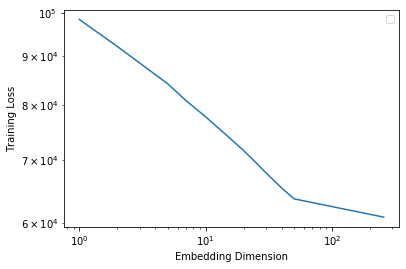

In [13]:
pylab.loglog(embedding_dims, final_train_losses)
pylab.xlabel("Embedding Dimension")
pylab.ylabel("Training Loss")
pylab.legend()

No handles with labels found to put in legend.


Best dimension found: 12


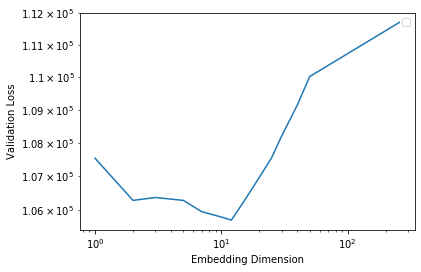

In [14]:
pylab.loglog(embedding_dims, final_val_losses)
pylab.xlabel("Embedding Dimension")
pylab.ylabel("Validation Loss")
pylab.legend()
print(f"Best dimension found: {embedding_dims[np.argmin(final_val_losses)]}")

Answer the following questions:

1.  Given the vocabulary size $V$ and embedding dimensionality $d$, how many parameters does the GLoVE model have?
2.  Write the gradient of the loss function with respect to one parameter vector $\mathbf{w}_i$.
3.  Implement the gradient update of GLoVE.
4.  Train the model with varying dimensionality $d$.
Which $d$ leads to optimal validation performance?
Why does / doesn't larger $d$ always lead to better validation error?


# Part 2: Network Architecture (2pts)
See the handout for the written questions in this part.

# Part 3: Training the model (4pts)

There are three classes defined in this *part*: *Params*, *Activations*, *Model*.
You will make changes to *Model*, but it may help to read through *Params* and *Activations* first.

In [15]:
class Params(object):
    """A class representing the trainable parameters of the model. This class has five fields:
    
           word_embedding_weights, a matrix of size N_V x D, where N_V is the number of words in the vocabulary
                   and D is the embedding dimension.
           embed_to_hid_weights, a matrix of size N_H x 3D, where N_H is the number of hidden units. The first D
                   columns represent connections from the embedding of the first context word, the next D columns
                   for the second context word, and so on.
           hid_bias, a vector of length N_H
           hid_to_output_weights, a matrix of size N_V x N_H
           output_bias, a vector of length N_V"""

    def __init__(self, word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                 hid_bias, output_bias):
        self.word_embedding_weights = word_embedding_weights
        self.embed_to_hid_weights = embed_to_hid_weights
        self.hid_to_output_weights = hid_to_output_weights
        self.hid_bias = hid_bias
        self.output_bias = output_bias

    def copy(self):
        return self.__class__(self.word_embedding_weights.copy(), self.embed_to_hid_weights.copy(),
                              self.hid_to_output_weights.copy(), self.hid_bias.copy(), self.output_bias.copy())

    @classmethod
    def zeros(cls, vocab_size, context_len, embedding_dim, num_hid):
        """A constructor which initializes all weights and biases to 0."""
        word_embedding_weights = np.zeros((vocab_size, embedding_dim))
        embed_to_hid_weights = np.zeros((num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.zeros((vocab_size, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size)
        return cls(word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                   hid_bias, output_bias)

    @classmethod
    def random_init(cls, init_wt, vocab_size, context_len, embedding_dim, num_hid):
        """A constructor which initializes weights to small random values and biases to 0."""
        word_embedding_weights = np.random.normal(0., init_wt, size=(vocab_size, embedding_dim))
        embed_to_hid_weights = np.random.normal(0., init_wt, size=(num_hid, context_len * embedding_dim))
        hid_to_output_weights = np.random.normal(0., init_wt, size=(vocab_size, num_hid))
        hid_bias = np.zeros(num_hid)
        output_bias = np.zeros(vocab_size)
        return cls(word_embedding_weights, embed_to_hid_weights, hid_to_output_weights,
                   hid_bias, output_bias)

    ###### The functions below are Python's somewhat oddball way of overloading operators, so that
    ###### we can do arithmetic on Params instances. You don't need to understand this to do the assignment.

    def __mul__(self, a):
        return self.__class__(a * self.word_embedding_weights,
                              a * self.embed_to_hid_weights,
                              a * self.hid_to_output_weights,
                              a * self.hid_bias,
                              a * self.output_bias)

    def __rmul__(self, a):
        return self * a

    def __add__(self, other):
        return self.__class__(self.word_embedding_weights + other.word_embedding_weights,
                              self.embed_to_hid_weights + other.embed_to_hid_weights,
                              self.hid_to_output_weights + other.hid_to_output_weights,
                              self.hid_bias + other.hid_bias,
                              self.output_bias + other.output_bias)

    def __sub__(self, other):
        return self + -1. * other

In [16]:
class Activations(object):
    """A class representing the activations of the units in the network. This class has three fields:

        embedding_layer, a matrix of B x 3D matrix (where B is the batch size and D is the embedding dimension),
                representing the activations for the embedding layer on all the cases in a batch. The first D
                columns represent the embeddings for the first context word, and so on.
        hidden_layer, a B x N_H matrix representing the hidden layer activations for a batch
        output_layer, a B x N_V matrix representing the output layer activations for a batch"""

    def __init__(self, embedding_layer, hidden_layer, output_layer):
        self.embedding_layer = embedding_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer

def get_batches(inputs, targets, batch_size, shuffle=True):
    """Divide a dataset (usually the training set) into mini-batches of a given size. This is a
    'generator', i.e. something you can use in a for loop. You don't need to understand how it
    works to do the assignment."""

    if inputs.shape[0] % batch_size != 0:
        raise RuntimeError('The number of data points must be a multiple of the batch size.')
    num_batches = inputs.shape[0] // batch_size

    if shuffle:
        idxs = np.random.permutation(inputs.shape[0])
        inputs = inputs[idxs, :]
        targets = targets[idxs]

    for m in range(num_batches):
        yield inputs[m * batch_size:(m + 1) * batch_size, :], \
              targets[m * batch_size:(m + 1) * batch_size]

In this part of the assignment, you implement a method which computes the gradient using backpropagation.
To start you out, the *Model* class contains several important methods used in training:


*   *compute_activations* computes the activations of all units on a given input batch
*   *compute_loss* computes the total cross-entropy loss on a mini-batch
*   *evaluate* computes the average cross-entropy loss for a given set of inputs and targets

You will need to complete the implementation of two additional methods which are needed for training:


*   *compute_loss_derivative* computes the derivative of the loss function with respect to the output layer inputs.
*   *back_propagate* is the function which computes the gradient of the loss with respect to model parameters using backpropagation.
It uses the derivatives computed by *compute_loss_derivative*.
Some parts are already filled in for you, but you need to compute the matrices of derivatives for *embed_to_hid_weights*, *hid_bias*, *hid_to_output_weights*, and *output_bias*.
These matrices have the same sizes as the parameter matrices (see previous section).

In order to implement backpropagation efficiently, you need to express the computations in terms of matrix operations, rather than *for* loops.
You should first work through the derivatives on pencil and paper.
First, apply the chain rule to compute the derivatives with respect to individual units, weights, and biases.
Next, take the formulas you've derived, and express them in matrix form.
You should be able to express all of the required computations using only matrix multiplication, matrix transpose, and elementwise operations --- no *for* loops!
If you want inspiration, read through the code for *Model.compute_activations* and try to understand how the matrix operations correspond to the computations performed by all the units in the network.
        
To make your life easier, we have provided the routine *checking.check_gradients*, which checks your gradients using finite differences.
You should make sure this check passes before continuing with the assignment.





In [17]:
class Model(object):
    """A class representing the language model itself. This class contains various methods used in training
    the model and visualizing the learned representations. It has two fields:

        params, a Params instance which contains the model parameters
        vocab, a list containing all the words in the dictionary; vocab[0] is the word with index
               0, and so on."""

    def __init__(self, params, vocab):
        self.params = params
        self.vocab = vocab

        self.vocab_size = len(vocab)
        self.embedding_dim = self.params.word_embedding_weights.shape[1]
        self.embedding_layer_dim = self.params.embed_to_hid_weights.shape[1]
        self.context_len = self.embedding_layer_dim // self.embedding_dim
        self.num_hid = self.params.embed_to_hid_weights.shape[0]
#         print("Model config:")
#         print(f"Embedding dim: {self.embedding_dim}")
#         print(f"Embedding layer dim: {self.embedding_layer_dim}")
#         print(f"Hidden size: {self.num_hid}")

    def copy(self):
        return self.__class__(self.params.copy(), self.vocab[:])

    @classmethod
    def random_init(cls, init_wt, vocab, context_len, embedding_dim, num_hid):
        """Constructor which randomly initializes the weights to Gaussians with standard deviation init_wt
        and initializes the biases to all zeros."""
        params = Params.random_init(init_wt, len(vocab), context_len, embedding_dim, num_hid)
        return Model(params, vocab)

    def indicator_matrix(self, targets):
        """Construct a matrix where the kth entry of row i is 1 if the target for example
        i is k, and all other entries are 0."""
        batch_size = targets.size
        expanded_targets = np.zeros((batch_size, len(self.vocab)))
        expanded_targets[np.arange(batch_size), targets] = 1.
        return expanded_targets

    def compute_loss_derivative(self, output_activations, expanded_target_batch):
        """Compute the derivative of the cross-entropy loss function with respect to the inputs
        to the output units. In particular, the output layer computes the softmax

            y_i = e^{z_i} / \sum_j e^{z_j}.

        This function should return a batch_size x vocab_size matrix, where the (i, j) entry
        is dC / dz_j computed for the ith training case, where C is the loss function

            C = -sum(t_i log y_i).

        The arguments are as follows:

            output_activations - the activations of the output layer, i.e. the y_i's.
            expanded_target_batch - each row is the indicator vector for a target word,
                i.e. the (i, j) entry is 1 if the i'th word is j, and 0 otherwise."""

        ###########################   YOUR CODE HERE  ##############################
#         return expanded_target_batch * output_activations - expanded_target_batch
        return output_activations - expanded_target_batch  # batch_size x vocab_size
        ############################################################################

    def compute_loss(self, output_activations, expanded_target_batch):
        """Compute the total loss over a mini-batch. expanded_target_batch is the matrix obtained
        by calling indicator_matrix on the targets for the batch."""
        return -np.sum(expanded_target_batch * np.log(output_activations + TINY))

    def compute_activations(self, inputs):
        """Compute the activations on a batch given the inputs. Returns an Activations instance.
        You should try to read and understand this function, since this will give you clues for
        how to implement back_propagate."""

        batch_size = inputs.shape[0]
        if inputs.shape[1] != self.context_len:
            raise RuntimeError('Dimension of the input vectors should be {}, but is instead {}'.format(
                self.context_len, inputs.shape[1]))

        # Embedding layer
        # Look up the input word indies in the word_embedding_weights matrix
        embedding_layer_state = np.zeros((batch_size, self.embedding_layer_dim))
        for i in range(self.context_len):
            embedding_layer_state[:, i * self.embedding_dim:(i + 1) * self.embedding_dim] = \
                self.params.word_embedding_weights[inputs[:, i], :]

        # Hidden layer
        inputs_to_hid = np.dot(embedding_layer_state, self.params.embed_to_hid_weights.T) + \
                        self.params.hid_bias
        # Apply logistic activation function
        hidden_layer_state = 1. / (1. + np.exp(-inputs_to_hid))

        # Output layer
        inputs_to_softmax = np.dot(hidden_layer_state, self.params.hid_to_output_weights.T) + \
                            self.params.output_bias

        # Subtract maximum.
        # Remember that adding or subtracting the same constant from each input to a
        # softmax unit does not affect the outputs. So subtract the maximum to
        # make all inputs <= 0. This prevents overflows when computing their exponents.
        inputs_to_softmax -= inputs_to_softmax.max(1).reshape((-1, 1))

        output_layer_state = np.exp(inputs_to_softmax)
        output_layer_state /= output_layer_state.sum(1).reshape((-1, 1))

        return Activations(embedding_layer_state, hidden_layer_state, output_layer_state)

    def back_propagate(self, input_batch, activations, loss_derivative):
        """Compute the gradient of the loss function with respect to the trainable parameters
        of the model. The arguments are as follows:

             input_batch - the indices of the context words
             activations - an Activations class representing the output of Model.compute_activations
             loss_derivative - the matrix of derivatives computed by compute_loss_derivative
             
        Part of this function is already completed, but you need to fill in the derivative
        computations for hid_to_output_weights_grad, output_bias_grad, embed_to_hid_weights_grad,
        and hid_bias_grad. See the documentation for the Params class for a description of what
        these matrices represent."""

        # The matrix with values dC / dz_j, where dz_j is the input to the jth hidden unit,
        # i.e. y_j = 1 / (1 + e^{-z_j})
        hid_deriv = np.dot(loss_derivative, self.params.hid_to_output_weights) \
                    * activations.hidden_layer * (1. - activations.hidden_layer)

        ###########################   YOUR CODE HERE  ##############################
        hid_to_output_weights_grad = loss_derivative.T @ activations.hidden_layer
        output_bias_grad = np.sum(loss_derivative, axis=0)
        embed_to_hid_weights_grad = hid_deriv.T @ activations.embedding_layer
        hid_bias_grad = np.sum(hid_deriv, axis=0)
        ############################################################################

        # The matrix of derivatives for the embedding layer
        embed_deriv = np.dot(hid_deriv, self.params.embed_to_hid_weights)

        # Embedding layer
        word_embedding_weights_grad = np.zeros((self.vocab_size, self.embedding_dim))
        for w in range(self.context_len):
            word_embedding_weights_grad += np.dot(self.indicator_matrix(input_batch[:, w]).T,
                                                  embed_deriv[:, w * self.embedding_dim:(w + 1) * self.embedding_dim])

        return Params(word_embedding_weights_grad, embed_to_hid_weights_grad, hid_to_output_weights_grad,
                      hid_bias_grad, output_bias_grad)

    def evaluate(self, inputs, targets, batch_size=100):
        """Compute the average cross-entropy over a dataset.

            inputs: matrix of shape D x N
            targets: one-dimensional matrix of length N"""

        ndata = inputs.shape[0]

        total = 0.
        for input_batch, target_batch in get_batches(inputs, targets, batch_size):
            activations = self.compute_activations(input_batch)
            expanded_target_batch = self.indicator_matrix(target_batch)
            cross_entropy = -np.sum(expanded_target_batch * np.log(activations.output_layer + TINY))
            total += cross_entropy

        return total / float(ndata)

    def display_nearest_words(self, word, k=10):
        """List the k words nearest to a given word, along with their distances."""

        if word not in self.vocab:
            print('Word "{}" not in vocabulary.'.format(word))
            return

        # Compute distance to every other word.
        idx = self.vocab.index(word)
        word_rep = self.params.word_embedding_weights[idx, :]
        diff = self.params.word_embedding_weights - word_rep.reshape((1, -1))
        distance = np.sqrt(np.sum(diff ** 2, axis=1))

        # Sort by distance.
        order = np.argsort(distance)
        order = order[1:1 + k]  # The nearest word is the query word itself, skip that.
        for i in order:
            print('{}: {}'.format(self.vocab[i], distance[i]))

    def predict_next_word(self, word1, word2, word3, k=10):
        """List the top k predictions for the next word along with their probabilities.
        Inputs:
            word1: The first word as a string.
            word2: The second word as a string.
            word3: The third word as a string.
            k: The k most probable predictions are shown.
        Example usage:
            model.predict_next_word('john', 'might', 'be', 3)
            model.predict_next_word('life', 'in', 'new', 3)"""

        if word1 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
        if word2 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))
        if word3 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word3))

        idx1, idx2, idx3 = self.vocab.index(word1), self.vocab.index(word2), self.vocab.index(word3)
        input = np.array([idx1, idx2, idx3]).reshape((1, -1))
        activations = self.compute_activations(input)
        prob = activations.output_layer.ravel()
        idxs = np.argsort(prob)[::-1]  # sort descending
        for i in idxs[:k]:
            print('{} {} {} {} Prob: {:1.5f}'.format(word1, word2, word3, self.vocab[i], prob[i]))

    def word_distance(self, word1, word2):
        """Compute the distance between the vector representations of two words."""

        if word1 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
        if word2 not in self.vocab:
            raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))

        idx1, idx2 = self.vocab.index(word1), self.vocab.index(word2)
        word_rep1 = self.params.word_embedding_weights[idx1, :]
        word_rep2 = self.params.word_embedding_weights[idx2, :]
        diff = word_rep1 - word_rep2
        return np.sqrt(np.sum(diff ** 2))

To make your life easier, we have provided the routine *checking.check_gradients*, which checks your gradients using finite differences.
You should make sure this check passes before continuing with the assignment.

In [18]:
def relative_error(a, b):
    return np.abs(a - b) / (np.abs(a) + np.abs(b))


def check_output_derivatives(model, input_batch, target_batch):
    def softmax(z):
        z = z.copy()
        z -= z.max(1).reshape((-1, 1))
        y = np.exp(z)
        y /= y.sum(1).reshape((-1, 1))
        return y

    batch_size = input_batch.shape[0]
    z = np.random.normal(size=(batch_size, model.vocab_size))
    y = softmax(z)

    expanded_target_batch = model.indicator_matrix(target_batch)
    loss_derivative = model.compute_loss_derivative(y, expanded_target_batch)

    if loss_derivative is None:
        print('Loss derivative not implemented yet.')
        return False

    if loss_derivative.shape != (batch_size, model.vocab_size):
        print('Loss derivative should be size {} but is actually {}.'.format(
            (batch_size, model.vocab_size), loss_derivative.shape))
        return False

    def obj(z):
        y = softmax(z)
        return model.compute_loss(y, expanded_target_batch)

    for count in range(1000):
        i, j = np.random.randint(0, loss_derivative.shape[0]), np.random.randint(0, loss_derivative.shape[1])

        z_plus = z.copy()
        z_plus[i, j] += EPS
        obj_plus = obj(z_plus)

        z_minus = z.copy()
        z_minus[i, j] -= EPS
        obj_minus = obj(z_minus)

        empirical = (obj_plus - obj_minus) / (2. * EPS)
        rel = relative_error(empirical, loss_derivative[i, j])
        if rel > 1e-4:
            print('The loss derivative has a relative error of {}, which is too large.'.format(rel))
            return False

    print('The loss derivative looks OK.')
    return True


def check_param_gradient(model, param_name, input_batch, target_batch):
    activations = model.compute_activations(input_batch)
    expanded_target_batch = model.indicator_matrix(target_batch)
    loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch)
    param_gradient = model.back_propagate(input_batch, activations, loss_derivative)

    def obj(model):
        activations = model.compute_activations(input_batch)
        return model.compute_loss(activations.output_layer, expanded_target_batch)

    dims = getattr(model.params, param_name).shape
    is_matrix = (len(dims) == 2)

    if getattr(param_gradient, param_name).shape != dims:
        print('The gradient for {} should be size {} but is actually {}.'.format(
            param_name, dims, getattr(param_gradient, param_name).shape))
        return

    for count in range(1000):
        if is_matrix:
            slc = np.random.randint(0, dims[0]), np.random.randint(0, dims[1])
        else:
            slc = np.random.randint(dims[0])

        model_plus = model.copy()
        getattr(model_plus.params, param_name)[slc] += EPS
        obj_plus = obj(model_plus)

        model_minus = model.copy()
        getattr(model_minus.params, param_name)[slc] -= EPS
        obj_minus = obj(model_minus)

        empirical = (obj_plus - obj_minus) / (2. * EPS)
        exact = getattr(param_gradient, param_name)[slc]
        rel = relative_error(empirical, exact)
        if rel > 1e-4:
            print('The loss derivative has a relative error of {}, which is too large.'.format(rel))
            return False

    print('The gradient for {} looks OK.'.format(param_name))


def load_partially_trained_model():
    obj = pickle.load(open(PARTIALLY_TRAINED_MODEL, 'rb'))
    params = Params(obj['word_embedding_weights'], obj['embed_to_hid_weights'],
                                   obj['hid_to_output_weights'], obj['hid_bias'],
                                   obj['output_bias'])
    vocab = obj['vocab']
    return Model(params, vocab)


def check_gradients():
    """Check the computed gradients using finite differences."""
    np.random.seed(0)

    np.seterr(all='ignore')  # suppress a warning which is harmless

    model = load_partially_trained_model()
    data_obj = pickle.load(open(data_location, 'rb'))
    train_inputs, train_targets = data_obj['train_inputs'], data_obj['train_targets']
    input_batch = train_inputs[:100, :]
    target_batch = train_targets[:100]

    if not check_output_derivatives(model, input_batch, target_batch):
        return

    for param_name in ['word_embedding_weights', 'embed_to_hid_weights', 'hid_to_output_weights',
                       'hid_bias', 'output_bias']:
        check_param_gradient(model, param_name, input_batch, target_batch)


def print_gradients():
    """Print out certain derivatives for grading."""

    model = load_partially_trained_model()
    data_obj = pickle.load(open(data_location, 'rb'))
    train_inputs, train_targets = data_obj['train_inputs'], data_obj['train_targets']
    input_batch = train_inputs[:100, :]
    target_batch = train_targets[:100]

    activations = model.compute_activations(input_batch)
    expanded_target_batch = model.indicator_matrix(target_batch)
    loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch)
    param_gradient = model.back_propagate(input_batch, activations, loss_derivative)

    print('loss_derivative[2, 5]', loss_derivative[2, 5])
    print('loss_derivative[2, 121]', loss_derivative[2, 121])
    print('loss_derivative[5, 33]', loss_derivative[5, 33])
    print('loss_derivative[5, 31]', loss_derivative[5, 31])
    print()
    print('param_gradient.word_embedding_weights[27, 2]', param_gradient.word_embedding_weights[27, 2])
    print('param_gradient.word_embedding_weights[43, 3]', param_gradient.word_embedding_weights[43, 3])
    print('param_gradient.word_embedding_weights[22, 4]', param_gradient.word_embedding_weights[22, 4])
    print('param_gradient.word_embedding_weights[2, 5]', param_gradient.word_embedding_weights[2, 5])
    print()
    print('param_gradient.embed_to_hid_weights[10, 2]', param_gradient.embed_to_hid_weights[10, 2])
    print('param_gradient.embed_to_hid_weights[15, 3]', param_gradient.embed_to_hid_weights[15, 3])
    print('param_gradient.embed_to_hid_weights[30, 9]', param_gradient.embed_to_hid_weights[30, 9])
    print('param_gradient.embed_to_hid_weights[35, 21]', param_gradient.embed_to_hid_weights[35, 21])
    print()
    print('param_gradient.hid_bias[10]', param_gradient.hid_bias[10])
    print('param_gradient.hid_bias[20]', param_gradient.hid_bias[20])
    print()
    print('param_gradient.output_bias[0]', param_gradient.output_bias[0])
    print('param_gradient.output_bias[1]', param_gradient.output_bias[1])
    print('param_gradient.output_bias[2]', param_gradient.output_bias[2])
    print('param_gradient.output_bias[3]', param_gradient.output_bias[3])


In [19]:
check_gradients()
print_gradients()

The loss derivative looks OK.
The gradient for word_embedding_weights looks OK.
The gradient for embed_to_hid_weights looks OK.
The gradient for hid_to_output_weights looks OK.
The gradient for hid_bias looks OK.
The gradient for output_bias looks OK.
loss_derivative[2, 5] 0.001112231773782498
loss_derivative[2, 121] -0.9991004720395987
loss_derivative[5, 33] 0.0001903237803173703
loss_derivative[5, 31] -0.7999757709589483

param_gradient.word_embedding_weights[27, 2] -0.27199539981936866
param_gradient.word_embedding_weights[43, 3] 0.8641722267354154
param_gradient.word_embedding_weights[22, 4] -0.2546730202374648
param_gradient.word_embedding_weights[2, 5] 0.0

param_gradient.embed_to_hid_weights[10, 2] -0.6526990313918256
param_gradient.embed_to_hid_weights[15, 3] -0.13106433000472612
param_gradient.embed_to_hid_weights[30, 9] 0.118467746181694
param_gradient.embed_to_hid_weights[35, 21] -0.10004526104604386

param_gradient.hid_bias[10] 0.25376638738156415
param_gradient.hid_bias[20

Once you've implemented the gradient computation, you'll need to train the model.
The function *train* implements the main training procedure.
It takes two arguments:


*   *embedding_dim*: The number of dimensions in the distributed representation.
*   *num_hid*: The number of hidden units


As the model trains, the script prints out some numbers that tell you how well the training is going.
It shows:


*   The cross entropy on the last 100 mini-batches of the training set. This is shown after every 100 mini-batches.
*   The cross entropy on the entire validation set every 1000 mini-batches of training.

At the end of training, this function shows the cross entropies on the training, validation and test sets.
It will return a *Model* instance.

In [20]:
_train_inputs = None
_train_targets = None
_vocab = None

DEFAULT_TRAINING_CONFIG = {'batch_size': 100,  # the size of a mini-batch
                           'learning_rate': 0.1,  # the learning rate
                           'momentum': 0.9,  # the decay parameter for the momentum vector
                           'epochs': 50,  # the maximum number of epochs to run
                           'init_wt': 0.01,  # the standard deviation of the initial random weights
                           'context_len': 3,  # the number of context words used
                           'show_training_CE_after': 100,  # measure training error after this many mini-batches
                           'show_validation_CE_after': 1000,  # measure validation error after this many mini-batches
                           }


def find_occurrences(word1, word2, word3):
    """Lists all the words that followed a given tri-gram in the training set and the number of
    times each one followed it."""

    # cache the data so we don't keep reloading
    global _train_inputs, _train_targets, _vocab
    if _train_inputs is None:
        data_obj = pickle.load(open(data_location, 'rb'))
        _vocab = data_obj['vocab']
        _train_inputs, _train_targets = data_obj['train_inputs'], data_obj['train_targets']

    if word1 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word1))
    if word2 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word2))
    if word3 not in _vocab:
        raise RuntimeError('Word "{}" not in vocabulary.'.format(word3))

    idx1, idx2, idx3 = _vocab.index(word1), _vocab.index(word2), _vocab.index(word3)
    idxs = np.array([idx1, idx2, idx3])

    matches = np.all(_train_inputs == idxs.reshape((1, -1)), 1)

    if np.any(matches):
        counts = collections.defaultdict(int)
        for m in np.where(matches)[0]:
            counts[_vocab[_train_targets[m]]] += 1

        word_counts = sorted(list(counts.items()), key=lambda t: t[1], reverse=True)
        print('The tri-gram "{} {} {}" was followed by the following words in the training set:'.format(
            word1, word2, word3))
        for word, count in word_counts:
            if count > 1:
                print('    {} ({} times)'.format(word, count))
            else:
                print('    {} (1 time)'.format(word))
    else:
        print('The tri-gram "{} {} {}" did not occur in the training set.'.format(word1, word2, word3))


def train(embedding_dim, num_hid, config=DEFAULT_TRAINING_CONFIG):
    """This is the main training routine for the language model. It takes two parameters:

        embedding_dim, the dimension of the embeddilanguage_model.pyng space
        num_hid, the number of hidden units."""

    # Load the data
    data_obj = pickle.load(open(data_location, 'rb'))
    vocab = data_obj['vocab']
    train_inputs, train_targets = data_obj['train_inputs'], data_obj['train_targets']
    valid_inputs, valid_targets = data_obj['valid_inputs'], data_obj['valid_targets']
    test_inputs, test_targets = data_obj['test_inputs'], data_obj['test_targets']

    # Randomly initialize the trainable parameters
    model = Model.random_init(config['init_wt'], vocab, config['context_len'], embedding_dim, num_hid)

    # Variables used for early stopping
    best_valid_CE = np.infty
    end_training = False

    # Initialize the momentum vector to all zeros
    delta = Params.zeros(len(vocab), config['context_len'], embedding_dim, num_hid)

    this_chunk_CE = 0.
    batch_count = 0
    for epoch in range(1, config['epochs'] + 1):
        if end_training:
            break

        print()
        print('Epoch', epoch)

        for m, (input_batch, target_batch) in enumerate(get_batches(train_inputs, train_targets,
                                                                    config['batch_size'])):
            batch_count += 1

            # Forward propagate
            activations = model.compute_activations(input_batch)

            # Compute loss derivative
            expanded_target_batch = model.indicator_matrix(target_batch)
            loss_derivative = model.compute_loss_derivative(activations.output_layer, expanded_target_batch)
            loss_derivative /= config['batch_size']

            # Measure loss function
            cross_entropy = model.compute_loss(activations.output_layer, expanded_target_batch) / config['batch_size']
            this_chunk_CE += cross_entropy
            if batch_count % config['show_training_CE_after'] == 0:
                print('Batch {} Train CE {:1.3f}'.format(
                    batch_count, this_chunk_CE / config['show_training_CE_after']))
                this_chunk_CE = 0.

            # Backpropagate
            loss_gradient = model.back_propagate(input_batch, activations, loss_derivative)

            # Update the momentum vector and model parameters
            delta = config['momentum'] * delta + loss_gradient
            model.params -= config['learning_rate'] * delta

            # Validate
            if batch_count % config['show_validation_CE_after'] == 0:
                print('Running validation...')
                cross_entropy = model.evaluate(valid_inputs, valid_targets)
                print('Validation cross-entropy: {:1.3f}'.format(cross_entropy))

                if cross_entropy > best_valid_CE:
                    print('Validation error increasing!  Training stopped.')
                    end_training = True
                    break

                best_valid_CE = cross_entropy

    print()
    train_CE = model.evaluate(train_inputs, train_targets)
    print('Final training cross-entropy: {:1.3f}'.format(train_CE))
    valid_CE = model.evaluate(valid_inputs, valid_targets)
    print('Final validation cross-entropy: {:1.3f}'.format(valid_CE))
    test_CE = model.evaluate(test_inputs, test_targets)
    print('Final test cross-entropy: {:1.3f}'.format(test_CE))

    return model

Run the training.


In [21]:
embedding_dim = 16
num_hid = 128
trained_model = train(embedding_dim, num_hid)


Epoch 1
Batch 100 Train CE 4.528
Batch 200 Train CE 4.464
Batch 300 Train CE 4.464
Batch 400 Train CE 4.426
Batch 500 Train CE 4.454
Batch 600 Train CE 4.434
Batch 700 Train CE 4.418
Batch 800 Train CE 4.429
Batch 900 Train CE 4.413
Batch 1000 Train CE 4.416
Running validation...
Validation cross-entropy: 4.399
Batch 1100 Train CE 4.370
Batch 1200 Train CE 4.311
Batch 1300 Train CE 4.207
Batch 1400 Train CE 4.176
Batch 1500 Train CE 4.111
Batch 1600 Train CE 4.086
Batch 1700 Train CE 4.084
Batch 1800 Train CE 4.019
Batch 1900 Train CE 3.997
Batch 2000 Train CE 3.999
Running validation...
Validation cross-entropy: 3.980
Batch 2100 Train CE 3.978
Batch 2200 Train CE 3.908
Batch 2300 Train CE 3.900
Batch 2400 Train CE 3.862
Batch 2500 Train CE 3.848
Batch 2600 Train CE 3.743
Batch 2700 Train CE 3.721
Batch 2800 Train CE 3.675
Batch 2900 Train CE 3.589
Batch 3000 Train CE 3.550
Running validation...
Validation cross-entropy: 3.560
Batch 3100 Train CE 3.537
Batch 3200 Train CE 3.519
Batch 

To convince us that you have correctly implemented the gradient computations, please include the following with your assignment submission:



*   You will submit *language_model.ipynb* through MarkUs.
You do not need to modify any of the code except the parts we asked you to implement.
*   In your writeup, include the output of the function *print_gradients*.
This prints out part of the gradients for a partially trained network which we have provided, and we will check them against the correct outputs. **Important:** make sure to give the output of *print_gradients*, not *check_gradients*.

This is worth 4 points: 1 for the loss derivatives, 1 for the bias gradients, and 2 for the weight gradients.
Since we gave you a gradient checker, you have no excuse for not getting full points on this part.



# Part 4: Analysis (4pts)

In this part, you will analyze the representation learned by the network. You should first train a
model with a 16-dimensional embedding and 128 hidden units, as discussed in the previous section;
you’ll use this trained model for the remainder of this section.
Important: if you’ve made any fixes
to your gradient code, you must reload the language_model module and then re-run the training
procedure.
Python does not reload modules automatically, and you don’t want to accidentally
analyze an old version of your model.

These methods of the Model class can be used for analyzing the model after the training is
done:



*   *display_nearest_words* lists the words whose embedding vectors are nearest to the given
word
*   *word_distance* computes the distance between the embeddings of two words
*   *predict_next_word* shows the possible next words the model considers most likely, along
with their probabilities


We also include:


*    *tsne_plot_representation* creates a 2-dimensional embedding of the distributed representation space using
an algorithm called t-SNE. (You don’t need to know what this is for the assignment, but we
may cover it later in the course.) Nearby points in this 2-D space are meant to correspond to
nearby points in the 16-D space.

In [22]:
import numpy as Math

def Hbeta(D=Math.array([]), beta=1.0):
    """Compute the perplexity and the P-row for a specific value of the precision of a Gaussian distribution."""

    # Compute P-row and corresponding perplexity
    P = Math.exp(-D.copy() * beta);
    sumP = sum(P);
    H = Math.log(sumP) + beta * Math.sum(D * P) / sumP;
    P = P / sumP;
    return H, P;


def x2p(X=Math.array([]), tol=1e-5, perplexity=30.0):
    """Performs a binary search to get P-values in such a way that each conditional Gaussian has the same perplexity."""

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape;
    sum_X = Math.sum(Math.square(X), 1);
    D = Math.add(Math.add(-2 * Math.dot(X, X.T), sum_X).T, sum_X);
    P = Math.zeros((n, n));
    beta = Math.ones((n, 1));
    logU = Math.log(perplexity);

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point ", i, " of ", n, "...")

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -Math.inf;
        betamax = Math.inf;
        Di = D[i, Math.concatenate((Math.r_[0:i], Math.r_[i + 1:n]))];
        (H, thisP) = Hbeta(Di, beta[i]);

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU;
        tries = 0;
        while Math.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i];
                if betamax == Math.inf or betamax == -Math.inf:
                    beta[i] = beta[i] * 2;
                else:
                    beta[i] = (beta[i] + betamax) / 2;
            else:
                betamax = beta[i];
                if betamin == Math.inf or betamin == -Math.inf:
                    beta[i] = beta[i] / 2;
                else:
                    beta[i] = (beta[i] + betamin) / 2;

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i]);
            Hdiff = H - logU;
            tries = tries + 1;

        # Set the final row of P
        P[i, Math.concatenate((Math.r_[0:i], Math.r_[i + 1:n]))] = thisP;

    # Return final P-matrix
    print("Mean value of sigma: ", Math.mean(Math.sqrt(1 / beta)))
    return P;


def pca(X=Math.array([]), no_dims=50):
    """Runs PCA on the NxD array X in order to reduce its dimensionality to no_dims dimensions."""

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape;
    X = X - Math.tile(Math.mean(X, 0), (n, 1));
    (l, M) = Math.linalg.eig(Math.dot(X.T, X));
    Y = Math.dot(X, M[:, 0:no_dims]);
    return Y;


def tsne(X=Math.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """Runs t-SNE on the dataset in the NxD array X to reduce its dimensionality to no_dims dimensions.
    The syntaxis of the function is Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array."""

    # Check inputs
    if X.dtype != "float64":
        print("Error: array X should have type float64.");
        return -1;
    # if no_dims.__class__ != "<type 'int'>":			# doesn't work yet!
    #	print("Error: number of dimensions should be an integer.");
    #	return -1;

    # Initialize variables
    X = pca(X, initial_dims);
    (n, d) = X.shape;
    max_iter = 1000;
    initial_momentum = 0.5;
    final_momentum = 0.8;
    eta = 500;
    min_gain = 0.01;
    Y = Math.random.randn(n, no_dims);
    dY = Math.zeros((n, no_dims));
    iY = Math.zeros((n, no_dims));
    gains = Math.ones((n, no_dims));

    # Compute P-values
    P = x2p(X, 1e-5, perplexity);
    P = P + Math.transpose(P);
    P = P / Math.sum(P);
    P = P * 4;  # early exaggeration
    P = Math.maximum(P, 1e-12);

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = Math.sum(Math.square(Y), 1);
        num = 1 / (1 + Math.add(Math.add(-2 * Math.dot(Y, Y.T), sum_Y).T, sum_Y));
        num[range(n), range(n)] = 0;
        Q = num / Math.sum(num);
        Q = Math.maximum(Q, 1e-12);

        # Compute gradient
        PQ = P - Q;
        for i in range(n):
            dY[i, :] = Math.sum(Math.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0);

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0));
        gains[gains < min_gain] = min_gain;
        iY = momentum * iY - eta * (gains * dY);
        Y = Y + iY;
        Y = Y - Math.tile(Math.mean(Y, 0), (n, 1));

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = Math.sum(P * Math.log(P / Q));
            print("Iteration ", (iter + 1), ": error is ", C)

        # Stop lying about P-values
        if iter == 100:
            P = P / 4;

    # Return solution
    return Y;

def tsne_plot_representation(model):
    """Plot a 2-D visualization of the learned representations using t-SNE."""
    print(model.params.word_embedding_weights.shape)
    mapped_X = tsne(model.params.word_embedding_weights)
    pylab.figure()
    for i, w in enumerate(model.vocab):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

def tsne_plot_GLoVE_representation(W_final, b_final):
    """Plot a 2-D visualization of the learned representations using t-SNE."""
    mapped_X = tsne(W_final)
    pylab.figure()
    data_obj = pickle.load(open(data_location, 'rb'))
    for i, w in enumerate(data_obj['vocab']):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

def plot_2d_GLoVE_representation(W_final, b_final):
    """Plot a 2-D visualization of the learned representations."""
    mapped_X = W_final
    pylab.figure()
    data_obj = pickle.load(open(data_location, 'rb'))
    for i, w in enumerate(data_obj['vocab']):
        pylab.text(mapped_X[i, 0], mapped_X[i, 1], w)
    pylab.xlim(mapped_X[:, 0].min(), mapped_X[:, 0].max())
    pylab.ylim(mapped_X[:, 1].min(), mapped_X[:, 1].max())
    pylab.show()

Using these methods, please answer the following questions, each of which is worth 1 point.



1.   Pick three words from the vocabulary that go well together (for example, ‘*government of united*’,
‘*city of new*’, ‘*life in the*’, ‘*he is the*’ etc.).
Use the model to predict the next word.
Does the model give sensible predictions?
Try to find an example where it makes a plausible prediction even though the 4-gram wasn’t present in the dataset (*raw_sentences.txt*).
To help you out, the function *find_occurrences* lists the words that appear after a given 3-gram in the training set.
2.   Plot the 2-dimensional visualization using the method *tsne_plot_representation*.
Look at the plot and find a few clusters of related words.
What do the words in each cluster have in common?
Plot the 2-dimensional visualization using the method *tsne_plot_GLoVE_representation* for a 256 dimensional embedding.
How do the t-SNE embeddings for both models compare?
Plot the 2-dimensional visualization using the method *plot_2d_GLoVE_representation*.
How does this compare to the t-SNE embeddings?
(You don’t need to include the plots with your submission.)

3.   Are the words ‘*new*’ and ‘*york*’ close together in the learned representation?
Why or why not?
4.   Which pair of words is closer together in the learned representation: (‘*government*’, ‘*political*’), or (‘*government*’, ‘*university*’)?
Why do you think this is?



(250, 16)
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  250 ...
Mean value of sigma:  1.1399524522539968
Iteration  10 : error is  13.50635803046933
Iteration  20 : error is  12.730432808244565
Iteration  30 : error is  13.904916395171774
Iteration  40 : error is  13.879657884245479
Iteration  50 : error is  14.179534367173666
Iteration  60 : error is  13.887146094560935
Iteration  70 : error is  13.615183250925538
Iteration  80 : error is  13.910656690837426
Iteration  90 : error is  13.266266067210763
Iteration  100 : error is  13.676127827295229
Iteration  110 : error is  1.9377837685545989
Iteration  120 : error is  1.4498062119134056
Iteration  130 : error is  1.194899154683873
Iteration  140 : error is  1.0380947390064983
Iteration  150 : error is  0.9419106463189579
Iteration  160 : error is  0.9015317061461723
Iteration  170 : error is  0.8691041626178131
Iteration  180 : error is  0.8319619918173544
Iteration  190 : er

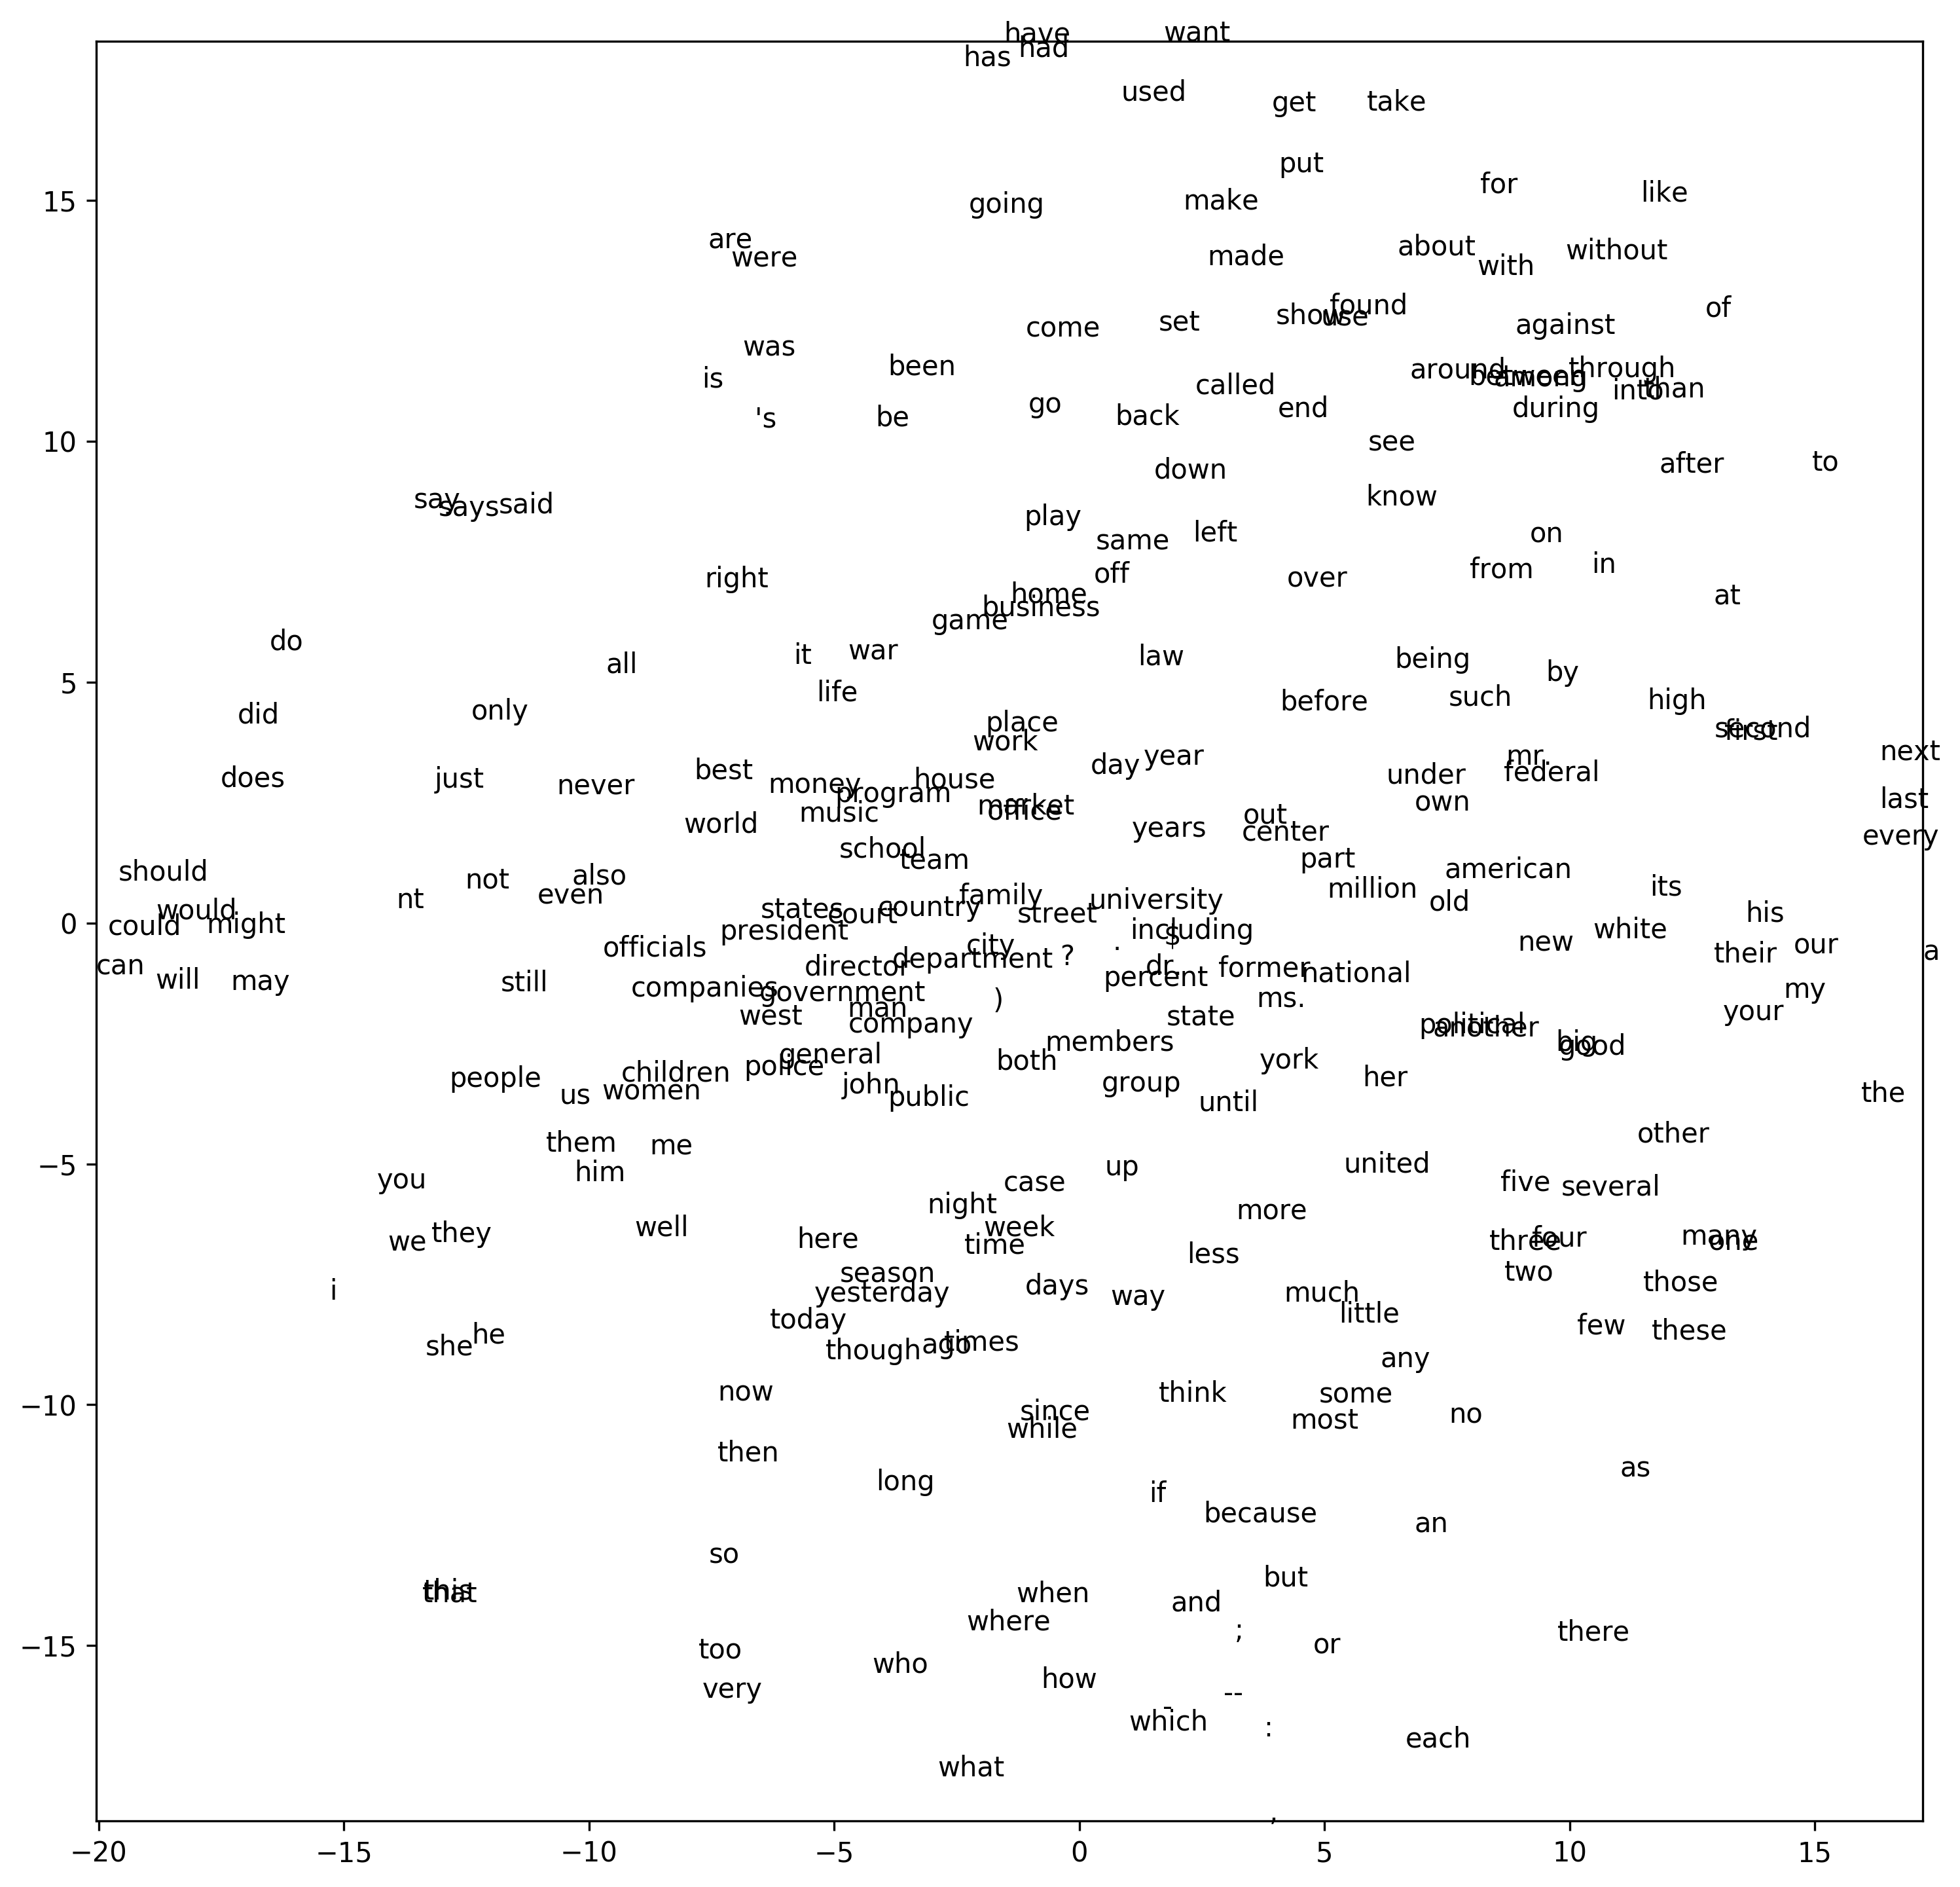

In [23]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 12)
plt.rcParams["figure.dpi"] = 300
tsne_plot_representation(trained_model)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  250 ...


/Library/Python/3.7/site-packages/ipykernel_launcher.py:64: ComplexWarning: Casting complex values to real discards the imaginary part


Mean value of sigma:  0.7434499269370554
Iteration  10 : error is  17.009553078828418
Iteration  20 : error is  16.388353317754277
Iteration  30 : error is  18.169956636768177
Iteration  40 : error is  17.74941058894297
Iteration  50 : error is  17.37396380344372
Iteration  60 : error is  18.085988670379752
Iteration  70 : error is  18.23018767462927
Iteration  80 : error is  18.018438898541703
Iteration  90 : error is  18.004694590191452
Iteration  100 : error is  18.875415444310327
Iteration  110 : error is  2.7798026774325892
Iteration  120 : error is  2.252791396402419
Iteration  130 : error is  1.9960570942004228
Iteration  140 : error is  1.866361258143521
Iteration  150 : error is  1.7889450940908846
Iteration  160 : error is  1.6637685347279472
Iteration  170 : error is  1.5642740903623933
Iteration  180 : error is  1.4414632793325635
Iteration  190 : error is  1.389150489896479
Iteration  200 : error is  1.3325107675917254
Iteration  210 : error is  1.288369459946453
Iteration

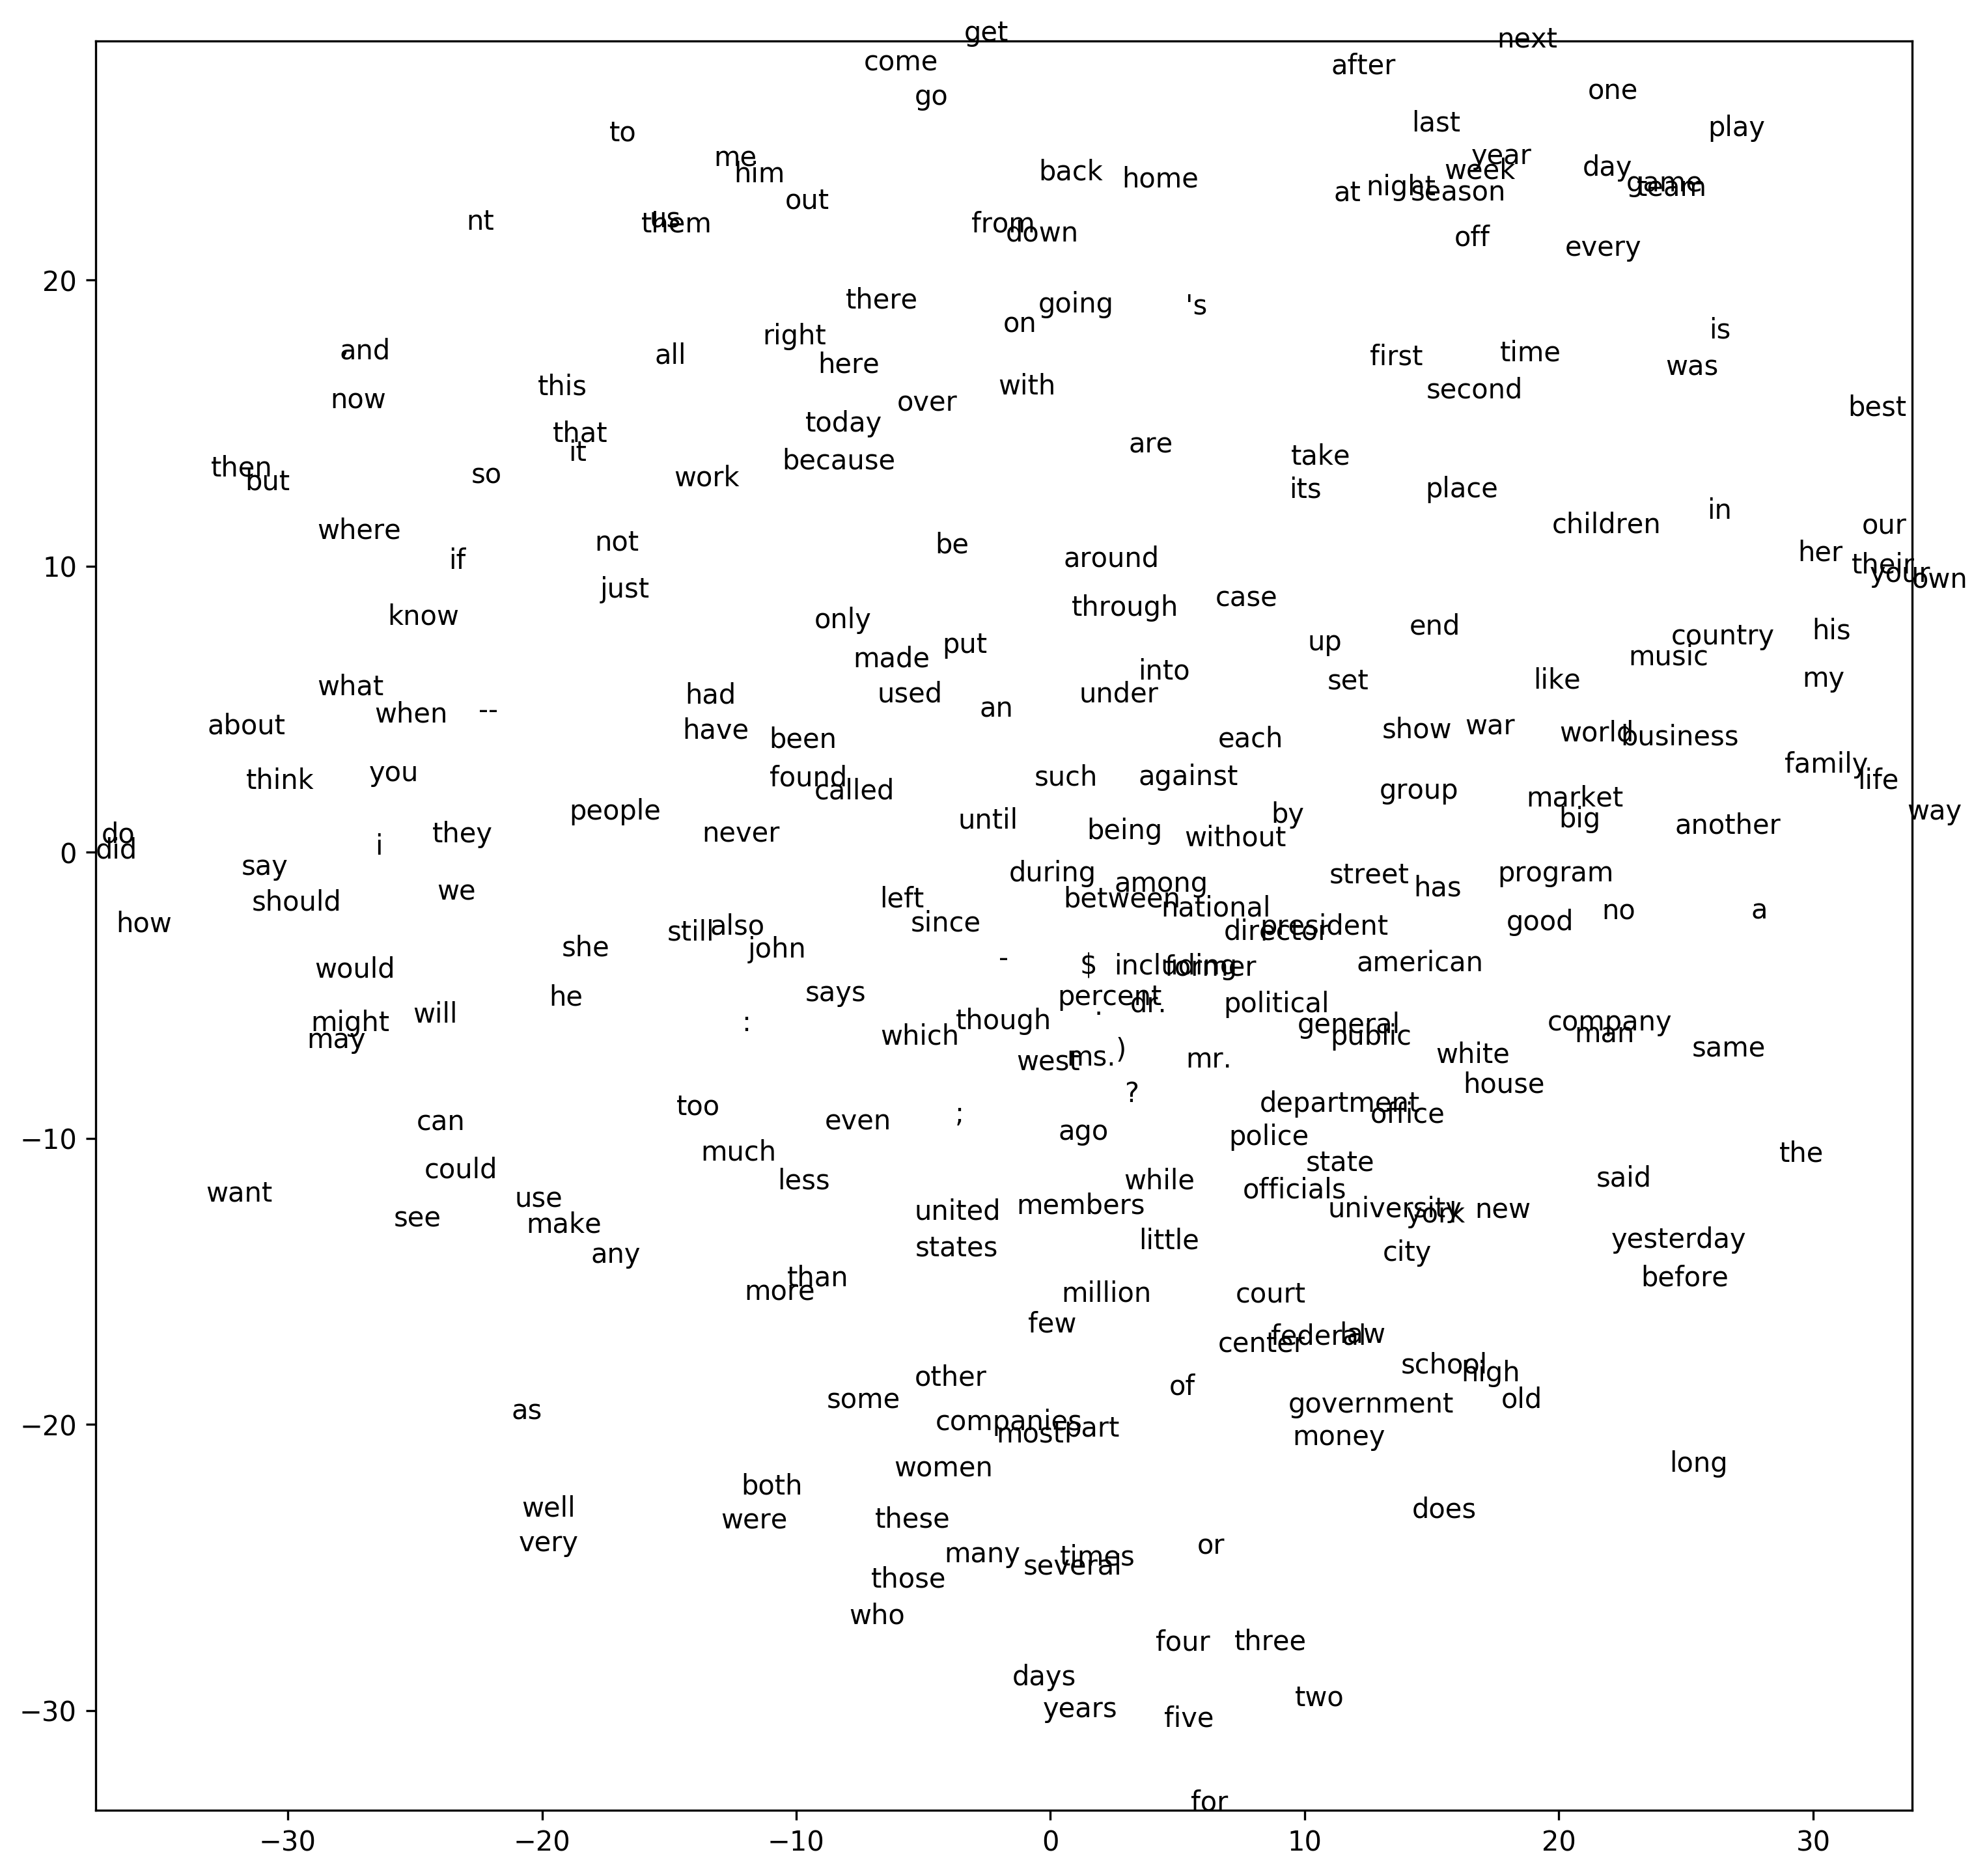

In [24]:
tsne_plot_GLoVE_representation(W_final, b_final)

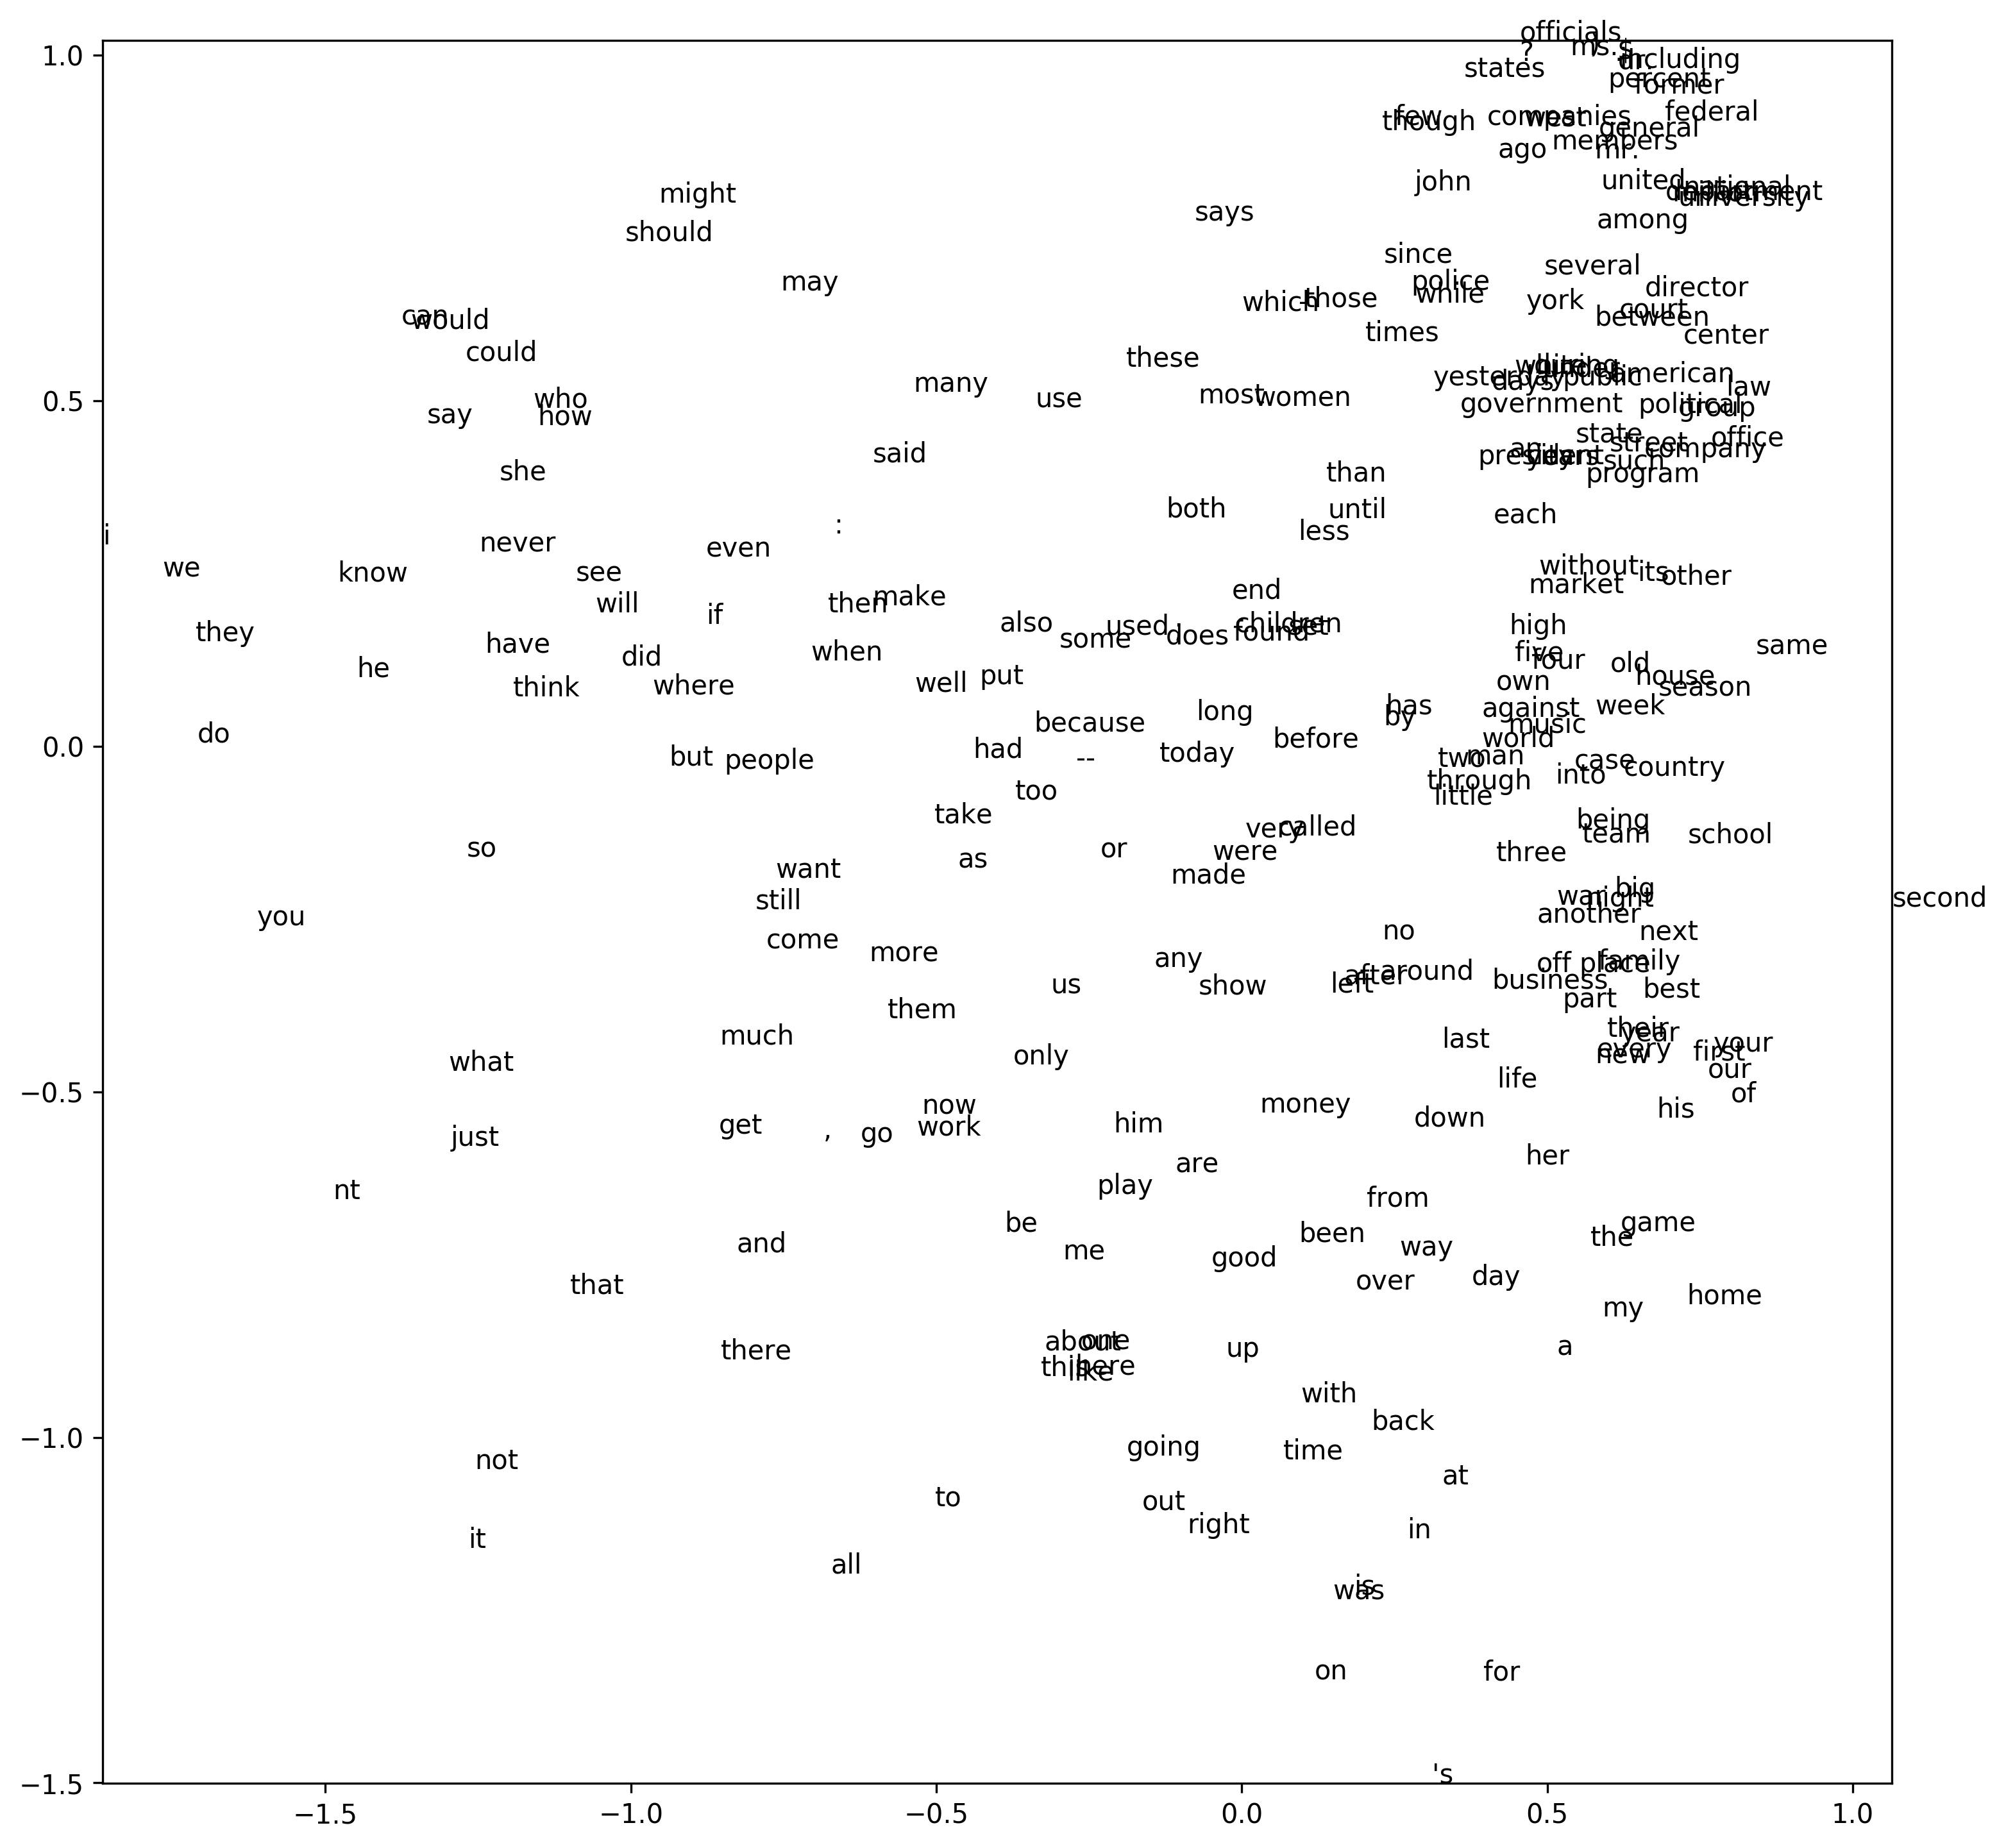

In [25]:
plot_2d_GLoVE_representation(W_final_2d, b_final_2d)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  250 ...
Mean value of sigma:  0.23915790027001896
Iteration  10 : error is  11.993632926555179
Iteration  20 : error is  10.172214256633849
Iteration  30 : error is  10.340880604603262
Iteration  40 : error is  10.598979788334386
Iteration  50 : error is  10.453317396586474
Iteration  60 : error is  10.433353823068758
Iteration  70 : error is  10.474190234507704
Iteration  80 : error is  10.382153343927573
Iteration  90 : error is  10.520917079015462
Iteration  100 : error is  10.440944014699657
Iteration  110 : error is  0.9363233523147417
Iteration  120 : error is  0.5396097333683412
Iteration  130 : error is  0.427899940927424
Iteration  140 : error is  0.3620250260096841
Iteration  150 : error is  0.3388770119857402
Iteration  160 : error is  0.33099254401965444
Iteration  170 : error is  0.32791835354227317
Iteration  180 : error is  0.32605679292636836
Iteration  190 : error i

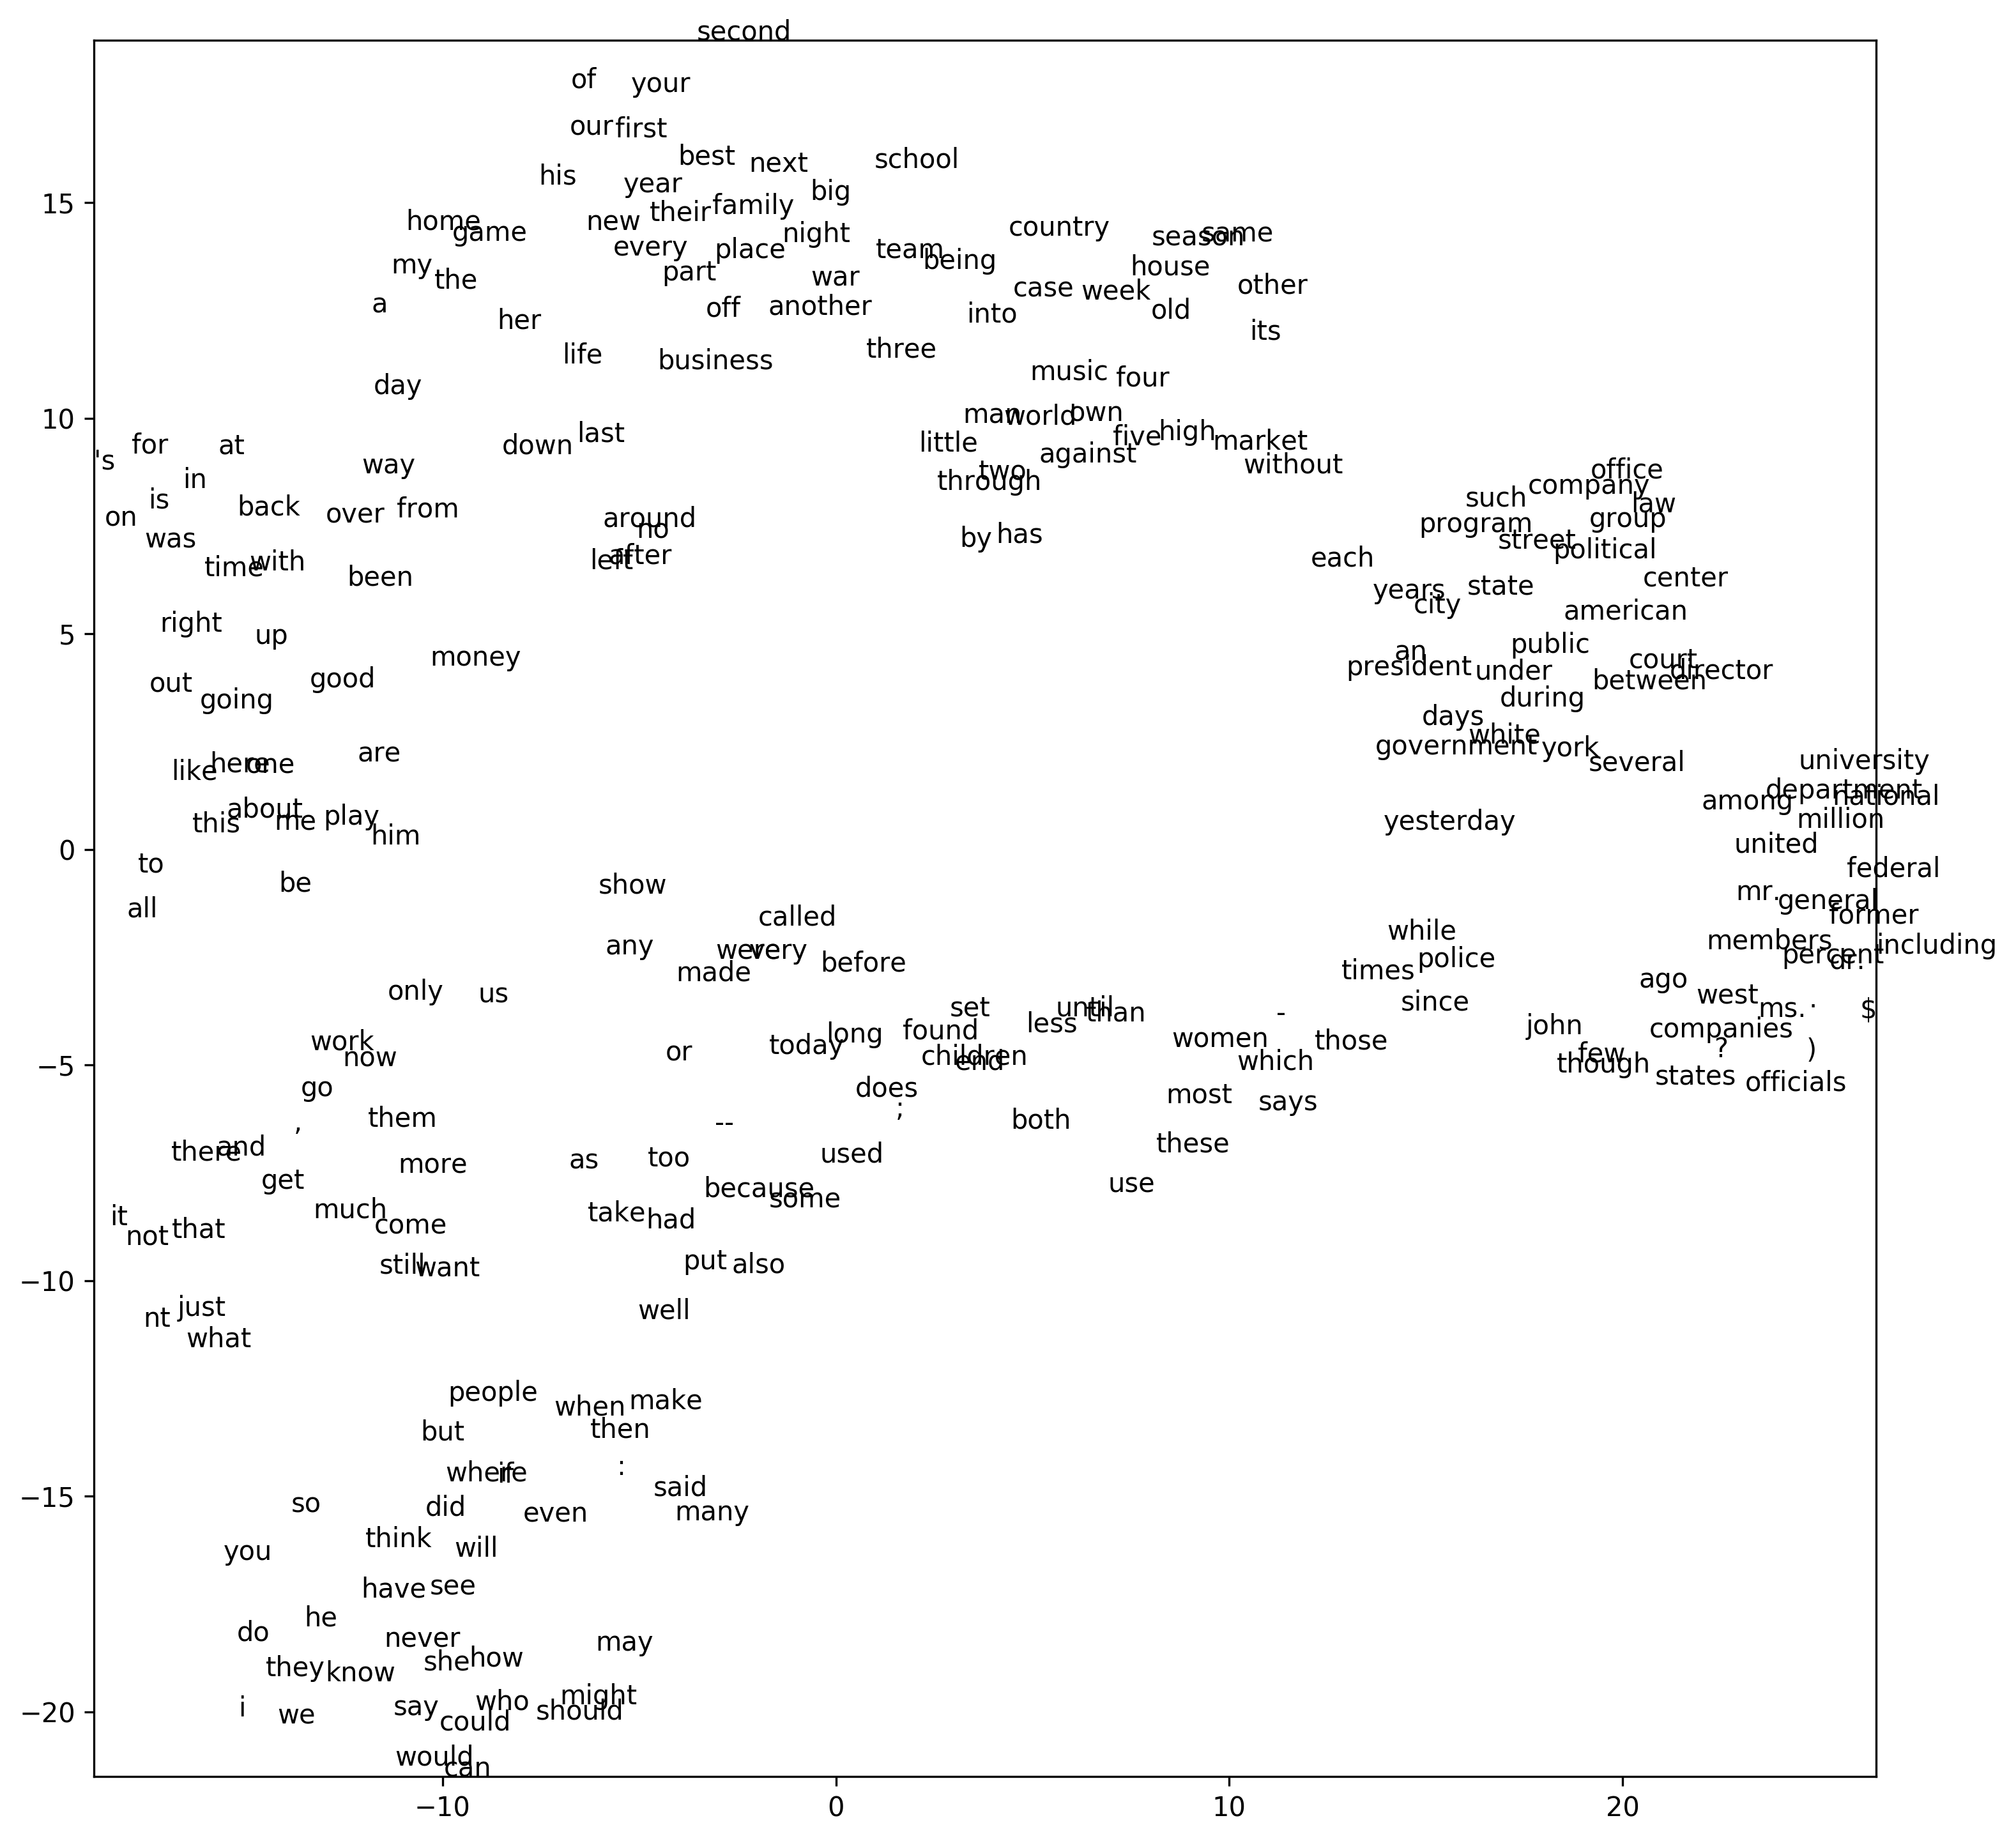

In [26]:
tsne_plot_GLoVE_representation(W_final_2d, b_final_2d)

In [27]:
# For part 4 Q1
trained_model.predict_next_word("government", "of", "united")
trained_model.predict_next_word("city", "of", "new")
trained_model.predict_next_word("life", "in", "the")

government of united own Prob: 0.06786
government of united states Prob: 0.06067
government of united life Prob: 0.05791
government of united money Prob: 0.05206
government of united . Prob: 0.05050
government of united end Prob: 0.04033
government of united time Prob: 0.03520
government of united house Prob: 0.03320
government of united say Prob: 0.02317
government of united team Prob: 0.02231
city of new york Prob: 0.98987
city of new . Prob: 0.00139
city of new ? Prob: 0.00080
city of new , Prob: 0.00078
city of new days Prob: 0.00059
city of new children Prob: 0.00058
city of new times Prob: 0.00055
city of new years Prob: 0.00033
city of new music Prob: 0.00033
city of new people Prob: 0.00030
life in the world Prob: 0.15756
life in the first Prob: 0.13498
life in the end Prob: 0.05317
life in the united Prob: 0.04379
life in the street Prob: 0.04040
life in the game Prob: 0.03705
life in the country Prob: 0.03588
life in the school Prob: 0.02934
life in the place Prob: 0.02903
li

In [28]:
find_occurrences("life", "in", "the")

The tri-gram "life in the" was followed by the following words in the training set:
    big (7 times)
    united (2 times)
    world (1 time)
    department (1 time)


In [29]:
# Q2


In [30]:
# Q3
dist = np.zeros([vocab_size, vocab_size])
for i, word_i in enumerate(data["vocab"]):
    for j, word_j in enumerate(data["vocab"]):
        dist[i, j] = trained_model.word_distance(word_i, word_j)

In [31]:
print(trained_model.word_distance("new", "york"))

3.903047513638595


In [32]:
trained_model.display_nearest_words("york")

school: 0.8158285996625793
ms.: 0.8451126543578821
city: 0.8613290798413148
?: 0.9136695622882397
national: 0.9436097103960857
university: 0.960730145147943
state: 0.9685329184950693
general: 0.9841914927765442
former: 1.0043426978578172
john: 1.0235336853560857


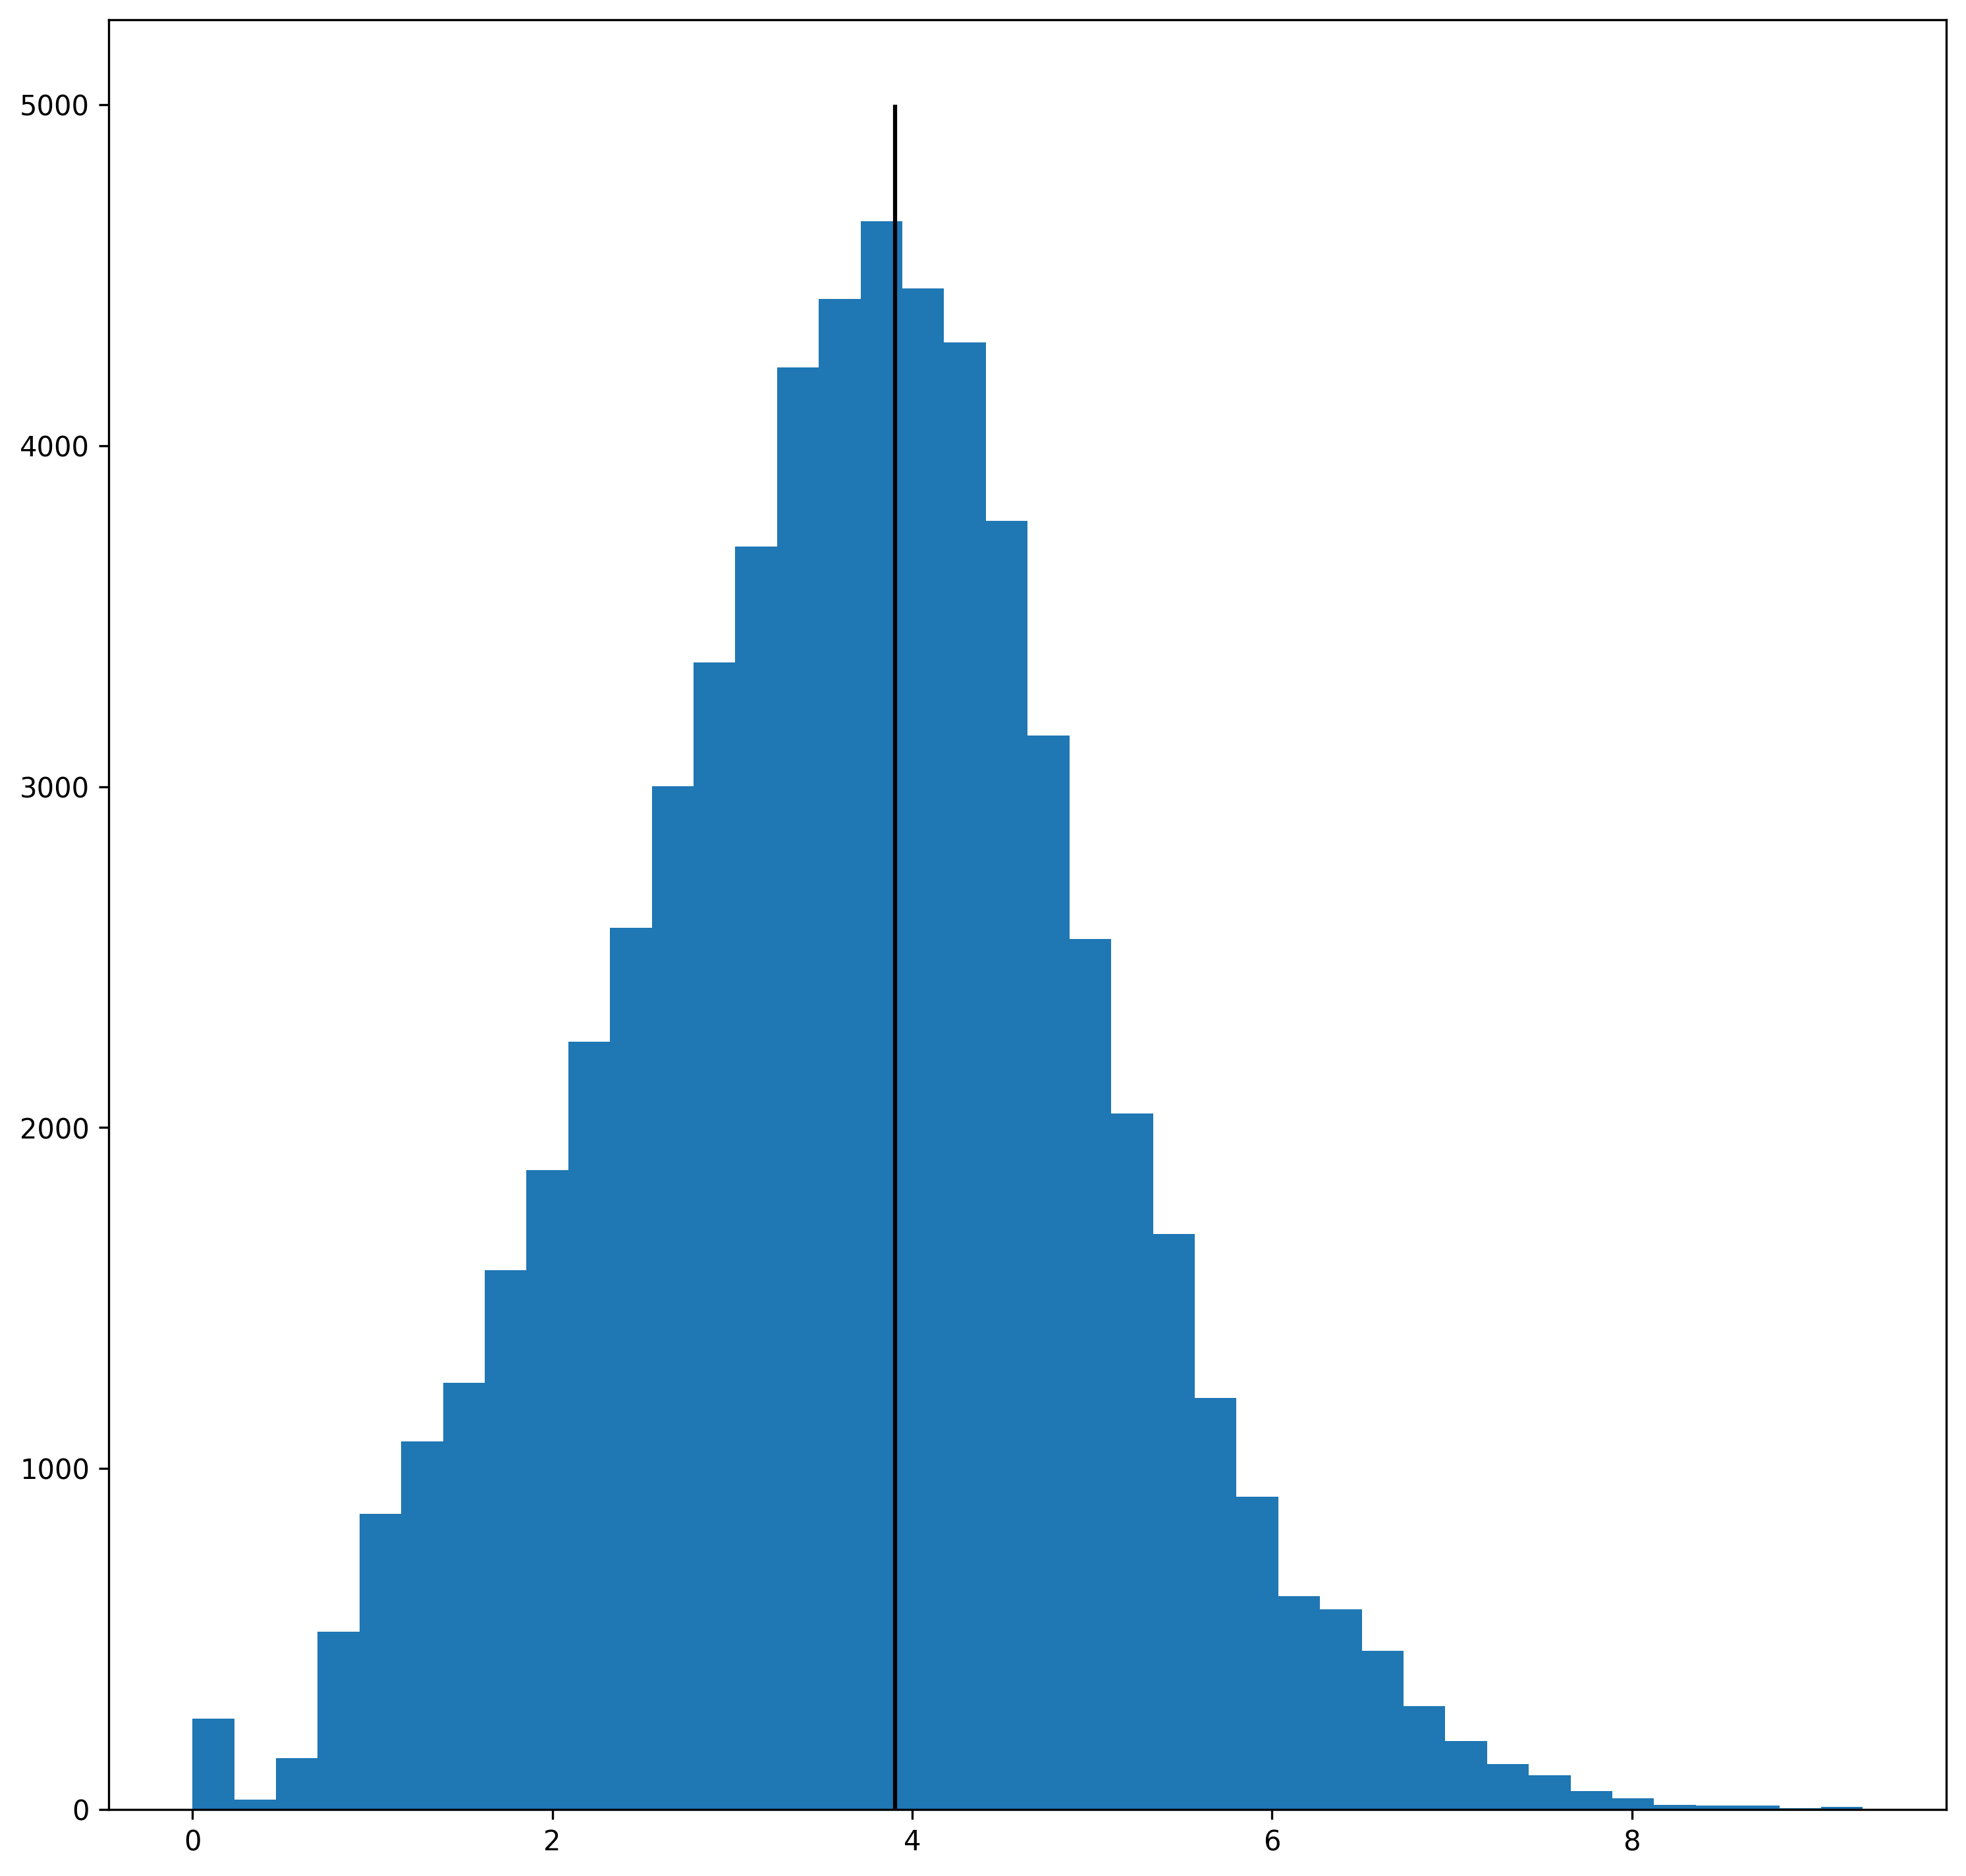

56.0256% Percentile


In [33]:
plt.hist(dist.reshape(-1,), bins=40)
plt.vlines(x=trained_model.word_distance("new", "york"), ymin=0, ymax=5000)
plt.show()
percentile = np.mean(dist <= trained_model.word_distance("new", "york"))*100
print(f"{percentile}% Percentile")

In [34]:
print(("government", "political"), trained_model.word_distance("government", "political"))
print(("government", "university"), trained_model.word_distance("government", "university"))

('government', 'political') 1.2808505981043723
('government', 'university') 1.1354211512227212


# What you have to submit

For reference, here is everything you need to hand in. See the top of this handout for submission
directions.



*   A PDF file titled *a1-writeup.pdf* containing the following:
Both questions from Part 2, the output of *print_gradients()*, answers to all four questions from Part 3.
*   Your code file *language_model.ipynb*
